# Imports

In [14]:
import os

os.chdir('/home/roberto/Github/De-Filippo-et-al-2022')

In [15]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dill
import numpy as np
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from rich import print
from tqdm.auto import tqdm
from time import perf_counter
from operator import itemgetter
from scipy.stats import zscore
from Utils.Settings import window_spike_hist, output_folder_calculations, neuropixel_dataset, var_thr, minimum_ripples_count_spike_analysis, minimum_ripples_count_generated_in_lateral_or_medial_spike_analysis
from Utils.Utils import acronym_to_main_area, clean_ripples_calculations, find_ripples_clusters_new, \
    batch_process_spike_hists_by_seed_location, process_spike_hists
import matplotlib.pyplot as plt
from multiprocessing import Pool, Manager
import seaborn as sns
import pingouin as pg
from Utils.Utils import color_to_labels, color_to_labels_custom_palette
from Utils.Style import palette_ML
from Utils.Utils import acronym_color_map
from statannotations.Annotator import Annotator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/alzheimer/Roberto/Software/mambaforge/envs/De-Filippo-et-al-2022/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/alzheimer/Roberto/Software/mambaforge/envs/De-Filippo-et-al-2022/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [16]:
pd.set_option('display.max_rows',40)
pd.set_option('display.max_columns', None)

In [23]:
t1_start = perf_counter()

manifest_path = f"{neuropixel_dataset}/manifest.json"

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

sessions = cache.get_session_table()
#ProfileReport(sessions)

with open(f"{output_folder_calculations}/clean_ripples_calculations.pkl", 'rb') as f:
    ripples_calcs = dill.load(f)


spike_hists = {}

input_rip = []
for session_id in ripples_calcs.keys():
    ripples = ripples_calcs[session_id][3].copy()
    ripples = ripples.groupby('Probe number-area').filter(lambda group: group['∫Ripple'].var() > var_thr)
    input_rip.append(ripples.groupby('Probe number-area').mean()['L-R (µm)'])

lr_space = pd.concat(input_rip)

medial_lim = lr_space.quantile(.33333)
lateral_lim = lr_space.quantile(.666666)
center = lr_space.median()
medial_lim_lm = medial_lim - 5691.510009765625
lateral_lim_lm = lateral_lim - 5691.510009765625

def l_m_classifier(row):
    if row['Source M-L (µm)'] < medial_lim_lm:
        v = 'Medial'
    elif row['Source M-L (µm)'] > lateral_lim_lm:
        v = 'Lateral'
    else:
        v = 'Central'
    return v

In [24]:

all_areas_recorded = [item for sublist in  sessions['ecephys_structure_acronyms'].to_list() for item in sublist]

count_areas_recorded = pd.Series(all_areas_recorded).value_counts()

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
count_areas_recorded.plot.bar(ax=ax)


In [6]:
ripples_calcs.keys()

dict_keys([715093703, 719161530, 721123822, 743475441, 744228101, 750332458, 750749662, 751348571, 754312389, 754829445, 755434585, 757216464, 757970808, 758798717, 759883607, 760345702, 761418226, 762602078, 763673393, 766640955, 767871931, 768515987, 771160300, 771990200, 773418906, 774875821, 778240327, 778998620, 779839471, 781842082, 786091066, 787025148, 789848216, 791319847, 793224716, 794812542, 797828357, 798911424, 799864342, 816200189, 819186360, 819701982, 821695405, 829720705, 831882777, 835479236, 839068429, 840012044, 847657808])

In [155]:
session_id = 715093703
spikes_summary = {}

In [223]:
def process(session_id, spikes_summary):
    print(session_id)

    session = cache.get_session_data(session_id)  # , amplitude_cutoff_maximum = np.inf, presence_ratio_minimum = -np.inf, isi_violations_maximum = np.inf)

    units = session.units
    units['parent area'] = units['ecephys_structure_acronym'].apply(lambda area: acronym_to_main_area(area))


    # #  each area, change output name accordingly
    areas = np.delete(units['parent area'].unique(),
                      np.argwhere(units['parent area'].unique() == 'grey'))  # delete grey if present

    if 'HPF' in areas:
        areas = ['HPF']
    else:
        return

    print(f"In session {session_id} areas recorded: {areas}")

    spike_times = session.spike_times

    ripples = ripples_calcs[session_id][3].copy()

    sel_probe = ripples_calcs[session_id][5]

    print(f"number ripples on best probe: {ripples[ripples['Probe number'] == sel_probe].shape[0]}")

    if ripples[ripples['Probe number'] == sel_probe].shape[0] < minimum_ripples_count_spike_analysis:
        return

    ripples = ripples.groupby('Probe number-area').filter(lambda group: group['∫Ripple'].var() > var_thr)

    ripples = ripples.sort_values(by='Start (s)').reset_index(drop=True)
    ripples = ripples[ripples['Area'] == 'CA1']
    ripples = ripples.reset_index().rename(columns={'index': 'Ripple number'})

    print(session_id, 'Recording in each ML section:',
          np.any(ripples['L-R (µm)'].unique() < medial_lim) & np.any(ripples['L-R (µm)'].unique() > lateral_lim) & \
          np.any((ripples['L-R (µm)'].unique() > medial_lim) & (ripples['L-R (µm)'].unique() < lateral_lim)))

    if np.any(ripples['L-R (µm)'].unique() < medial_lim) & np.any(ripples['L-R (µm)'].unique() > lateral_lim) & \
            np.any((ripples['L-R (µm)'].unique() > medial_lim) & (ripples['L-R (µm)'].unique() < lateral_lim)) == False:
        return

    ripples['Local strong'] = ripples.groupby('Probe number').apply(
        lambda x: x['∫Ripple'] > x['∫Ripple'].quantile(.9)).sort_index(level=1).values

    try:
        ripples['Z-scored ∫Ripple'] = ripples.groupby('Probe number-area').apply(
            lambda group: zscore(group['∫Ripple'], ddof=1)).droplevel(0)
    except:
        ripples['Z-scored ∫Ripple'] = ripples.groupby('Probe number-area').apply(
            lambda group: zscore(group['∫Ripple'], ddof=1)).T

    to_loop = []
    to_loop.append((ripples.groupby('Probe number-area').mean()['L-R (µm)'].sub(center).abs().idxmin(), 'central'))

    print(f"In session {session_id} process:{to_loop}")
    if ripples.shape[0] > 0:
        for source_area, type_source in to_loop:

            real_ripple_summary = find_ripples_clusters_new(ripples, source_area)
            real_ripple_summary = real_ripple_summary[real_ripple_summary['Spatial engagement']>.5]
            real_ripple_summary['Location seed'] = real_ripple_summary.apply(l_m_classifier, axis=1)

            print(f"in {session_id}, medial ripples number: {real_ripple_summary[real_ripple_summary['Location seed'] == 'Medial'].shape[0]}, " \
                  f"lateral ripples number: {real_ripple_summary[real_ripple_summary['Location seed'] == 'Lateral'].shape[0]}")
            if (real_ripple_summary[real_ripple_summary['Location seed'] == 'Medial'].shape[0] < minimum_ripples_count_generated_in_lateral_or_medial_spike_analysis) or \
                    (real_ripple_summary[real_ripple_summary['Location seed'] == 'Lateral'].shape[0] < minimum_ripples_count_generated_in_lateral_or_medial_spike_analysis):
                return

    field_to_use_to_compare = 'parent area'
    target_area = 'HPF'

    #space_sub_spike_times = dict(zip(units[units[field_to_use_to_compare] == target_area].index,
     #                                itemgetter(*units[units[field_to_use_to_compare] == target_area].index)(
     #                                    spike_times)))
    space_sub_spike_times = dict(zip(units.index,
                                     itemgetter(*units.index)(
                                         spike_times)))
    
    window = [.12, .12]
    spikes_per_ripple_medial = {}
    for cluster_id, spikes in tqdm(space_sub_spike_times.items()):
        _ = []
        ripple_start = []
        for index, row in real_ripple_summary[real_ripple_summary['Location seed'] == 'Medial'].iterrows():
            time_center = row['Start (s)'] + row[row.index.str.contains('lag')].min()# either sum zero or sum a negative value
            _.append(spikes[(spikes > time_center - window[0]) & (spikes < time_center + window[1])]-time_center)
            ripple_start.append(time_center)
        spikes_per_ripple_medial[cluster_id] = (_, ripple_start) 

    _ = [(key, np.concatenate(spikes_per_ripple_medial[key][0]), len(spikes_per_ripple_medial[key][0])) for key in spikes_per_ripple_medial.keys()]

    medial_ripple_firing_rate_0_120 = []
    medial_ripple_firing_rate_0_50 = []
    medial_ripple_firing_rate_50_120 = []
    medial_ripple_firing_rate_120_0 = []
    medial_ripple_firing_rate_20_0 = []
    medial_ripple_firing_rate_50_0 = []
    medial_ripple_firing_rate_120_20 = []
    for key, q, num_ripples in _:
        medial_ripple_firing_rate_0_120.append((key, ((len(q[q>0])/num_ripples)/12)))
        medial_ripple_firing_rate_0_50.append((key, ((len(q[(q>0) & (q<.05)])/num_ripples)/5)))
        medial_ripple_firing_rate_50_120.append((key, ((len(q[q>.05])/num_ripples)/7)))
        medial_ripple_firing_rate_120_0.append((key, ((len(q[(q>-.12) & (q<0)])/num_ripples)/12)))
        medial_ripple_firing_rate_20_0.append((key, ((len(q[(q>-.02) & (q<0)])/num_ripples)/2)))
        medial_ripple_firing_rate_50_0.append((key, ((len(q[(q>-.05) & (q<0)])/num_ripples)/5)))
        medial_ripple_firing_rate_120_20.append((key, ((len(q[(q>-.12) & (q<-.02)])/num_ripples)/10)))

    spikes_per_ripple_lateral = {}
    for cluster_id, spikes in tqdm(space_sub_spike_times.items()):
        _ = []
        ripple_start = []
        for index, row in real_ripple_summary[real_ripple_summary['Location seed'] == 'Lateral'].iterrows():
            time_center = row['Start (s)'] + row[row.index.str.contains('lag')].min()# either sum zero or sum a negative value
            _.append(spikes[(spikes > time_center - window[0]) & (spikes < time_center + window[1])]-time_center)
            ripple_start.append(time_center)
        spikes_per_ripple_lateral[cluster_id] = (_, ripple_start) 

    _ = [(key, np.concatenate(spikes_per_ripple_lateral[key][0]), len(spikes_per_ripple_lateral[key][0])) for key in spikes_per_ripple_lateral.keys()]

    lateral_ripple_firing_rate_0_120 = []
    lateral_ripple_firing_rate_0_50 = []
    lateral_ripple_firing_rate_50_120 = []
    lateral_ripple_firing_rate_120_0 = []
    lateral_ripple_firing_rate_20_0 = []
    lateral_ripple_firing_rate_50_0 = []
    lateral_ripple_firing_rate_120_20 = []
    for key, q, num_ripples in _:
        lateral_ripple_firing_rate_0_120.append((key, ((len(q[q>0])/num_ripples)/12)))
        lateral_ripple_firing_rate_0_50.append((key, ((len(q[(q>0) & (q<.05)])/num_ripples)/5)))
        lateral_ripple_firing_rate_50_120.append((key, ((len(q[q>.05])/num_ripples)/7)))
        lateral_ripple_firing_rate_120_0.append((key, ((len(q[(q>-.12) & (q<0)])/num_ripples)/12)))
        lateral_ripple_firing_rate_20_0.append((key, ((len(q[(q>-.02) & (q<0)])/num_ripples)/2)))
        lateral_ripple_firing_rate_50_0.append((key, ((len(q[(q>-.05) & (q<0)])/num_ripples)/5)))
        lateral_ripple_firing_rate_120_20.append((key, ((len(q[(q>-.12) & (q<-.02)])/num_ripples)/10)))


    mod_df = pd.concat([pd.DataFrame(medial_ripple_firing_rate_0_120, columns=['unit_id', 'Firing rate (0-120 ms) medial']), 
                        pd.DataFrame(medial_ripple_firing_rate_0_50, columns=['unit_id', 'Firing rate (0-50 ms) medial'])['Firing rate (0-50 ms) medial'],
                        pd.DataFrame(medial_ripple_firing_rate_50_120, columns=['unit_id', 'Firing rate (50-120 ms) medial'])['Firing rate (50-120 ms) medial'],
                       pd.DataFrame(medial_ripple_firing_rate_120_0, columns=['unit_id', 'Firing rate (120-0 ms) medial'])['Firing rate (120-0 ms) medial'],
                       pd.DataFrame(medial_ripple_firing_rate_20_0, columns=['unit_id', 'Firing rate (20-0 ms) medial'])['Firing rate (20-0 ms) medial'],
                       pd.DataFrame(medial_ripple_firing_rate_50_0, columns=['unit_id', 'Firing rate (50-0 ms) medial'])['Firing rate (50-0 ms) medial'],
                         pd.DataFrame(medial_ripple_firing_rate_120_20, columns=['unit_id', 'Firing rate (120-20 ms) medial'])['Firing rate (120-20 ms) medial'],
                       pd.DataFrame(lateral_ripple_firing_rate_0_120, columns=['unit_id', 'Firing rate (0-120 ms) lateral'])['Firing rate (0-120 ms) lateral'], 
                        pd.DataFrame(lateral_ripple_firing_rate_0_50, columns=['unit_id', 'Firing rate (0-50 ms) lateral'])['Firing rate (0-50 ms) lateral'],
                        pd.DataFrame(lateral_ripple_firing_rate_50_120, columns=['unit_id', 'Firing rate (50-120 ms) lateral'])['Firing rate (50-120 ms) lateral'],
                       pd.DataFrame(lateral_ripple_firing_rate_120_0, columns=['unit_id', 'Firing rate (120-0 ms) lateral'])['Firing rate (120-0 ms) lateral'],
                       pd.DataFrame(lateral_ripple_firing_rate_20_0, columns=['unit_id', 'Firing rate (20-0 ms) lateral'])['Firing rate (20-0 ms) lateral'],
                       pd.DataFrame(lateral_ripple_firing_rate_50_0, columns=['unit_id', 'Firing rate (50-0 ms) lateral'])['Firing rate (50-0 ms) lateral'],
                        pd.DataFrame(lateral_ripple_firing_rate_120_20, columns=['unit_id', 'Firing rate (120-20 ms) lateral'])['Firing rate (120-20 ms) lateral']],
                       axis=1).set_index('unit_id')
    out = pd.concat([units, mod_df], axis=1)#.groupby('ecephys_structure_acronym')[['modulation lat', 'modulation med']].mean()
    out['Session id'] = session_id
    spikes_summary[session_id] = out
    #print(out)
    return spikes_summary

In [224]:
%%time
_ = process(session_id, spikes_summary)


715093703

In session 715093703 areas recorded: ['HPF']

/alzheimer/Roberto/Software/mambaforge/envs/De-Filippo-et-al-2022/lib/python3.7/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:1348: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could "


number ripples on best probe: 3122

715093703 Recording in each ML section: True

In session 715093703 process:[('3-CA1', 'central')]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3450/3450 [00:40<00:00, 84.88it/s]


in 715093703, medial ripples number: 269, lateral ripples number: 389

  0%|          | 0/884 [00:00<?, ?it/s]

  0%|          | 0/884 [00:00<?, ?it/s]

CPU times: user 4min 41s, sys: 8.51 s, total: 4min 49s
Wall time: 5min 14s


In [ ]:
%%time 
#%%capture --no-stdout
manager = Manager()

spikes_summary = manager.dict()
input_multiprocessing = []
for ecephys_session_id in  list(ripples_calcs.keys())[::-1]:
        input_multiprocessing.append((ecephys_session_id, spikes_summary)) 

pool = Pool(processes=15) # Instantiate the pool here

pool.starmap_async(process, [x for x in input_multiprocessing])
pool.close()
pool.join()
print(len(spikes_summary))

In [226]:
spikes_summary = dict(spikes_summary)

In [227]:
with open(f"{output_folder_calculations}/units_summary_with_added_metrics.pkl", 'wb') as f:
    dill.dump(spikes_summary, f)


## Load data

In [20]:
with open(f"{output_folder_calculations}/units_summary_with_added_metrics.pkl", 'rb') as f:
    spikes_summary = dill.load(f)

In [25]:
summary_units_df = pd.concat(spikes_summary.values())

neurons_per_area = summary_units_df.groupby('ecephys_structure_acronym').size()

summary_units_df['Ripple modulation (0-50 ms) medial'] = (summary_units_df['Firing rate (0-50 ms) medial'] - summary_units_df['Firing rate (120-0 ms) medial'] )/ \
                                                            ( summary_units_df['Firing rate (120-0 ms) medial'])
summary_units_df['Ripple modulation (0-50 ms) lateral'] = (summary_units_df['Firing rate (0-50 ms) lateral'] - summary_units_df['Firing rate (120-0 ms) lateral']) / \
                                                            (summary_units_df['Firing rate (120-0 ms) lateral'])
summary_units_df['Ripple modulation (50-120 ms) medial'] = (summary_units_df['Firing rate (50-120 ms) medial']- summary_units_df['Firing rate (120-0 ms) medial']) / \
                                                               ( summary_units_df['Firing rate (120-0 ms) medial'])
summary_units_df['Ripple modulation (50-120 ms) lateral'] = (summary_units_df['Firing rate (50-120 ms) lateral']- summary_units_df['Firing rate (120-0 ms) lateral']) / \
                                                               ( summary_units_df['Firing rate (120-0 ms) lateral'])
summary_units_df['Ripple modulation (0-120 ms) medial'] = (summary_units_df['Firing rate (0-120 ms) medial'] - summary_units_df['Firing rate (120-0 ms) medial'])/ \
                                                            (summary_units_df['Firing rate (120-0 ms) medial'] )
summary_units_df['Ripple modulation (0-120 ms) lateral'] = (summary_units_df['Firing rate (0-120 ms) lateral']-summary_units_df['Firing rate (120-0 ms) lateral'])/\
                                                            ( summary_units_df['Firing rate (120-0 ms) lateral'])

summary_units_df['Pre-ripple modulation medial'] = (summary_units_df['Firing rate (20-0 ms) medial'] - summary_units_df['Firing rate (120-20 ms) medial'] ) / \
                                                (summary_units_df['Firing rate (120-20 ms) medial'] )
summary_units_df['Pre-ripple modulation lateral'] = (summary_units_df['Firing rate (20-0 ms) lateral']-summary_units_df['Firing rate (120-20 ms) lateral']) /  \
                                            (summary_units_df['Firing rate (120-20 ms) lateral'])


summary_units_df_sub = summary_units_df[(summary_units_df['ecephys_structure_acronym'].isin(count_areas_recorded[count_areas_recorded>8].index))&
                                        (summary_units_df['ecephys_structure_acronym'].isin(neurons_per_area[neurons_per_area>100].index))&
                                       (summary_units_df['ecephys_structure_acronym']!='grey')&
                                       (summary_units_df['ecephys_structure_acronym']!='HPF')]

summary_units_df_sub = summary_units_df_sub[~(summary_units_df_sub['Ripple modulation (0-50 ms) medial'].isin([np.nan, np.inf, -np.inf])) & 
                        ~(summary_units_df_sub['Ripple modulation (0-50 ms) lateral'].isin([np.nan, np.inf, -np.inf])) &
                        ~(summary_units_df_sub['Ripple modulation (50-120 ms) medial'].isin([np.nan, np.inf, -np.inf])) & 
                        ~(summary_units_df_sub['Ripple modulation (50-120 ms) lateral'].isin([np.nan, np.inf, -np.inf])) &
                        ~(summary_units_df_sub['Ripple modulation (0-120 ms) medial'].isin([np.nan, np.inf, -np.inf])) & 
                        ~(summary_units_df_sub['Ripple modulation (0-120 ms) lateral'].isin([np.nan, np.inf, -np.inf])) &
                        ~(summary_units_df_sub['Pre-ripple modulation medial'].isin([np.nan, np.inf, -np.inf]))&
                        ~(summary_units_df_sub['Pre-ripple modulation lateral'].isin([np.nan, np.inf, -np.inf]))]


summary_units_df_sub.columns = summary_units_df_sub.columns.str.replace('_', ' ')
summary_units_df_sub.columns = summary_units_df_sub.columns.str.capitalize()

summary_units_df_sub = summary_units_df_sub.rename(columns={"Left right ccf coordinate":"L-R", "Anterior posterior ccf coordinate":"A-P", "Dorsal ventral ccf coordinate":"D-V"})
summary_units_df_sub = summary_units_df_sub.rename(columns={"Ecephys structure acronym":"Brain region", "Parent area":"Parent brain region"})

summary_units_df_sub["M-L"] = summary_units_df_sub["L-R"] - 5691.510009765625

In [26]:
summary_units_df_sub['Diff pre-ripple modulation (20-0 ms)'] = (summary_units_df_sub['Pre-ripple modulation medial'] - summary_units_df_sub['Pre-ripple modulation lateral'])
summary_units_df_sub['Diff ripple modulation (0-50 ms)'] = (summary_units_df_sub['Ripple modulation (0-50 ms) medial'] - summary_units_df_sub['Ripple modulation (0-50 ms) lateral'])
summary_units_df_sub['Diff ripple modulation (50-120 ms)'] = (summary_units_df_sub['Ripple modulation (50-120 ms) medial'] - summary_units_df_sub['Ripple modulation (50-120 ms) lateral'])
summary_units_df_sub['Diff firing rate (0-50 ms)'] = (summary_units_df_sub['Firing rate (0-50 ms) medial'] - summary_units_df_sub['Firing rate (0-50 ms) lateral'])
summary_units_df_sub['Diff firing rate (50-120 ms)'] = (summary_units_df_sub['Firing rate (50-120 ms) medial'] - summary_units_df_sub['Firing rate (50-120 ms) lateral'])


In [27]:
palette_parent_areas = dict()
for area in summary_units_df_sub['Parent brain region'].unique():
    palette_parent_areas[area] = '#' + ''.join(f'{i:02X}' for i in acronym_color_map[area]);

## how many neurons modulate by ripples

In [38]:
def conditions_type_engagement(s):
    if (s['Ripple modulation (0-50 ms) medial']>.5) | (s['Ripple modulation (0-50 ms) lateral']>.5):
        if ((s['Ripple modulation (0-50 ms) medial'])/(s['Ripple modulation (0-50 ms) lateral']+1e-9))>2:
            return 'Medial ripple engagement'
        elif ((s['Ripple modulation (0-50 ms) lateral'])/(s['Ripple modulation (0-50 ms) medial']+1e-9))>2:
            return  'Lateral ripple engagement'
        else:
            return 'No preference'
    else:
            return 'No preference'
        
def conditions_ripple_engagement(s):
    if (s['Ripple modulation (0-50 ms) medial']>.5) | ((s['Ripple modulation (0-50 ms) lateral'])>.5):
        return 'Ripple engagement'
    else:
        return 'No engagement'

In [72]:
parent_area = 'HPF'
minimum_firing_rate_hz = .1
summary_units_df_sub_decent_firing = summary_units_df_sub[(summary_units_df_sub['Firing rate (0-50 ms) medial']>minimum_firing_rate_hz) |
                                                        (summary_units_df_sub['Firing rate (0-50 ms) lateral']>minimum_firing_rate_hz)].copy()
summary_units_df_sub_decent_firing['Ripple type engagement'] = summary_units_df_sub_decent_firing.apply(conditions_type_engagement, axis=1)
summary_units_df_sub_decent_firing['Ripple engagement'] = summary_units_df_sub_decent_firing.apply(conditions_ripple_engagement, axis=1)

In [73]:
ripple_mod_mean = pd.DataFrame(summary_units_df_sub_decent_firing.groupby(['Parent brain region', 'Session id'])['Ripple engagement'].value_counts(normalize=True, dropna=False))\
            .rename(columns={'Ripple engagement':'value'}).reset_index().groupby(['Parent brain region', 'Ripple engagement'])['value'].mean()

ripple_mod_sem = pd.DataFrame(summary_units_df_sub_decent_firing.groupby(['Parent brain region', 'Session id'])['Ripple engagement'].value_counts(normalize=True))\
            .rename(columns={'Ripple engagement':'value'}).reset_index().groupby(['Parent brain region', 'Ripple engagement'])['value'].sem()

In [74]:
ripple_mod_mean

Parent brain region  Ripple engagement
HPF                  No engagement        0.114251
                     Ripple engagement    0.885749
Isocortex            No engagement        0.947417
                     Ripple engagement    0.066421
MB                   No engagement        0.991457
                     Ripple engagement    0.081155
TH                   No engagement        1.000000
Name: value, dtype: float64

In [60]:
print(  f'We found that clusters located in the thalamus (TH) and midbrain (MB) were hardly modulated (MB: {round(100-ripple_mod_mean.loc["MB"]["No engagement"]*100, 2)} ± {round(ripple_mod_sem.loc["MB"]["No engagement"] *100, 2)} %, '
           f'TH: {round(100-ripple_mod_mean.loc["TH"]["No engagement"]*100, 2)} ± {round(ripple_mod_sem.loc["TH"]["No engagement"] *100, 2)} %), ' )

We found that clusters located in the thalamus (TH) and midbrain (MB) were hardly modulated (MB: 0.85 ± 0.59 %, TH:
0.0 ± 0.0 %),

In [61]:
f'{round(ripple_mod_mean.loc["HPF"]["Ripple engagement"]*100, 2)} ± {round(ripple_mod_sem.loc["HPF"]["Ripple engagement"] *100, 2)} %'


'88.57 ± 1.03 %'

In [51]:
ripple_mod_mean

Parent brain region  Ripple engagement
HPF                  No engagement        0.114251
                     Ripple engagement    0.885749
Isocortex            No engagement        0.947417
                     Ripple engagement    0.066421
MB                   No engagement        0.991457
                     Ripple engagement    0.081155
TH                   No engagement        1.000000
Name: value, dtype: float64

In [267]:
ripple_mod_sem

Parent brain region  Ripple engagement
HPF                  No engagement        0.009905
                     Ripple engagement    0.009905
Isocortex            No engagement        0.009953
                     Ripple engagement    0.010271
MB                   No engagement        0.006002
                     Ripple engagement    0.008418
TH                   No engagement        0.000000
Name: value, dtype: float64

In [ ]:
 summary_units_df_sub[((summary_units_df_sub['Firing rate (0-50 ms) medial']>minimum_firing_rate_hz) |\
                                                        (summary_units_df_sub['Firing rate (0-50 ms) lateral']>minimum_firing_rate_hz)) &
                            (summary_units_df_sub["Parent brain region"]=="Isocortex") &
                    (summary_units_df_sub['Ripple modulation (0-50 ms) lateral'] > .5) &
                            (summary_units_df_sub['Ripple modulation (0-50 ms) medial'] < .5) ]

In [558]:
 summary_units_df_sub[((summary_units_df_sub['Firing rate (0-50 ms) medial']>minimum_firing_rate_hz) |\
                                                        (summary_units_df_sub['Firing rate (0-50 ms) lateral']>minimum_firing_rate_hz)) &
                            (summary_units_df_sub["Parent brain region"]=="Isocortex") &
                    (summary_units_df_sub['Ripple modulation (0-50 ms) lateral'] > .5) |
                            (summary_units_df_sub['Ripple modulation (0-50 ms) medial'] > .5) ]

,L ratio,Waveform halfwidth,Waveform recovery slope,Peak channel id,Cluster id,Nn miss rate,Waveform duration,Max drift,Local index unit,Amplitude cutoff,Firing rate,Waveform repolarization slope,Waveform velocity above,D prime,Waveform pt ratio,Snr,Isolation distance,Waveform spread,Cumulative drift,Silhouette score,Isi violations,Waveform velocity below,Presence ratio,Nn hit rate,Waveform amplitude,C50 dg,Area rf,Fano dg,Fano dm,Fano fl,Fano rf,F1 f0 dg,G dsi dg,G osi dg,Azimuth rf,Mod idx dg,P value rf,Pref tf dg,Run mod dg,Run mod dm,Run mod fl,Run mod rf,Pref dir dm,Pref ori dg,Run pval dg,Run pval dm,Run pval fl,Run pval rf,Elevation rf,Pref speed dm,Firing rate dg,Firing rate dm,Firing rate fl,Firing rate rf,On off ratio fl,Time to peak dm,Pref tf multi dg,Pref dir multi dm,Pref ori multi dg,Pref speed multi dm,Lifetime sparseness dg,Lifetime sparseness dm,Lifetime sparseness fl,Lifetime sparseness rf,Probe vertical position,Probe horizontal position,Probe id,Channel local index,Ecephys structure id,Brain region,A-P,D-V,L-R,Probe description,Location,Probe sampling rate,Probe lfp sampling rate,Probe has lfp data,Parent brain region,Firing rate (0-120 ms) medial,Firing rate (0-50 ms) medial,Firing rate (50-120 ms) medial,Firing rate (120-0 ms) medial,Firing rate (20-0 ms) medial,Firing rate (50-0 ms) medial,Firing rate (120-20 ms) medial,Firing rate (0-120 ms) lateral,Firing rate (0-50 ms) lateral,Firing rate (50-120 ms) lateral,Firing rate (120-0 ms) lateral,Firing rate (20-0 ms) lateral,Firing rate (50-0 ms) lateral,Firing rate (120-20 ms) lateral,Session id,Fano ns,Fano sg,G osi sg,Pref sf sg,Run mod ns,Run mod sg,Pref ori sg,Run pval ns,Run pval sg,Pref image ns,Pref phase sg,Firing rate ns,Firing rate sg,Time to peak ns,Pref sf multi sg,Pref ori multi sg,Pref phase multi sg,Image selectivity ns,Pref image multi ns,Lifetime sparseness ns,Lifetime sparseness sg,Ripple modulation (0-50 ms) medial,Ripple modulation (0-50 ms) lateral,Ripple modulation (50-120 ms) medial,Ripple modulation (50-120 ms) lateral,Ripple modulation (0-120 ms) medial,Ripple modulation (0-120 ms) lateral,Pre-ripple modulation medial,Pre-ripple modulation lateral,M-L,Ripple type engagement,Ripple engagement,Firing rate (0-120 ms),Firing rate (120-0 ms),Firing rate (0-50 ms),Ripple engagement high spiking,Diff pre-ripple modulation (20-0 ms),Diff ripple modulation (0-50 ms),Diff ripple modulation (50-120 ms),Diff firing rate (0-50 ms),Diff firing rate (50-120 ms)
unit_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
951171225,1.338798e-02,0.137353,-0.275788,868929463,80,0.001744,0.192295,29.75,72,0.000909,10.952668,0.964320,0.343384,4.406536,0.661721,3.465294,56.680133,60.0,115.19,0.065734,0.030063,-0.206030,0.99,0.944667,228.80715,0.560918,100.0,18.954655,3.660606,0.973333,2.933333,0.377732,NaN,NaN,90.000,2.634712,0.150,2.0,0.995769,NaN,-1.000000,1.000000,-45.0,0.0,1.937661e-26,NaN,1.587262e-01,0.204833,-10.000,0.0050,18.751929,8.003808,0.079933,0.356363,NaN,0.2115,False,False,False,False,0.025280,0.143004,0.200000,0.521848,560,27,841435557,55,215.0,APN,7894.0,2906.0,7213.0,probeA,See electrode locations,30000.288456,1250.012019,True,MB,0.002222,0.002667,0.001905,0.000556,0.000000,0.000000,0.000667,0.001126,0.000000,0.001931,0.002252,0.000000,0.001351,0.002703,839068429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.800000,-1.000000,2.428571,-0.142857,3.000000,-0.500000,-1.000000,-1.000000,1521.48999,NaN,NaN,0.001674,0.001404,0.001896,NaN,2.000000,4.800000,2.571429,0.002667,-0.000026
951171258,6.620021e-12,0.192295,-0.063294,868929555,96,0.000000,0.645561,12.79,88,0.000311,1.820187,0.390663,0.686767,12.750003,0.486886,4.181569,193.462257,30.0,120.34,0.193588,0.022444,NaN,0.98,1.000000,148.46208,0.740612,200.0,2.640000,2.081159,1.536667,1.466667,0.820293,NaN,NaN,90.000,0.246953,0.651,2.0,0.699240,NaN,NaN,-1.000000,45.0,45.

In [226]:
pd.DataFrame(summary_units_df_sub.groupby(['Parent brain region', 'Session id'])['Ripple engagement'].value_counts(normalize=True))\
            .rename(columns={'Ripple engagement':'value'}).reset_index().groupby(['Parent brain region', 'Ripple engagement'])['value'].sem()

Parent brain region  Ripple engagement
HPF                  No engagement        0.012135
                     Ripple engagement    0.012135
Isocortex            No engagement        0.007268
                     Ripple engagement    0.007268
MB                   No engagement        0.010671
                     Ripple engagement    0.022689
TH                   No engagement        0.005259
                     Ripple engagement    0.005885
Name: value, dtype: float64

In [222]:
pd.DataFrame(summary_units_df_sub.groupby(['Parent brain region', 'Session id'])['Ripple engagement high spiking'].value_counts(normalize=True))\
            .rename(columns={'Ripple engagement high spiking':'value'}).reset_index().groupby(['Parent brain region', 'Ripple engagement high spiking'])['value'].mean()

Parent brain region  Ripple engagement high spiking
HPF                  No engagement                     0.107602
                     Ripple engagement                 0.892398
Isocortex            No engagement                     0.945715
                     Ripple engagement                 0.068571
MB                   No engagement                     0.991317
                     Ripple engagement                 0.082492
TH                   No engagement                     1.000000
Name: value, dtype: float64

## many HPF are positivey ripple modulated 

In [549]:

def plot_dist_ripple_mod(data, param, ax0):
    g = sns.kdeplot(data=data, x=param, 
                    hue='Ripple seed', palette=palette_ML, ax=ax0, fill=True, gridsize=500, cut=0)
    ax0.set_xlim((-1, 15))
    ax0.axvline(0,color= 'k', linestyle='--')
    ax0.axvline(.5,color= 'r', linestyle='--')
    ax0.get_yaxis().set_visible(False) 

    ax0.spines[['left']].set_visible(False)


    norm_test = pg.normality(data=data, dv=param, group="Ripple seed")


    if norm_test["normal"].all():
        p_val = pg.ttest(data[data["Ripple seed"] == "Medial"][param],
               data[data["Ripple seed"] == "Lateral"][param], paired=True)["p-val"][0]
        print("ttest: ", p_val)

    else:
        p_val = pg.wilcoxon(data[data["Ripple seed"]=="Medial"][param], data[data["Ripple seed"]=="Lateral"][param])["p-val"][0]
        cles = pg.wilcoxon(data[data["Ripple seed"]=="Medial"][param], data[data["Ripple seed"]=="Lateral"][param])["CLES"][0]
        print("mwu p-val and CLES: ", p_val, cles)

    if p_val<.05:
        ax0.text(.6, .7, "*",
                    transform=ax0.transAxes,
                    fontsize=15, ha='center', va='center');
        ax0.text(.6, .8,  f"p-value = {'{:.2e}'.format(p_val)}",
                        transform=ax0.transAxes,
                        fontsize=10, ha='center', va='center');



In [550]:
_ = summary_units_df_sub[(summary_units_df_sub['Firing rate (0-50 ms) medial']>minimum_firing_rate_hz) |
                                                        (summary_units_df_sub['Firing rate (0-50 ms) lateral']>minimum_firing_rate_hz)][['Ripple modulation (0-120 ms) medial', 'Ripple modulation (0-120 ms) lateral', 'Parent brain region']]

_ = pd.wide_to_long(_.reset_index(), stubnames='Ripple modulation (0-120 ms)', i=['Parent brain region','unit_id'], j="Ripple seed", sep=' ', suffix=r'\w+').reset_index()
_['Ripple seed'] = _["Ripple seed"].str.capitalize()


mwu p-val and CLES:  4.616395850227576e-50 0.5393896488728392

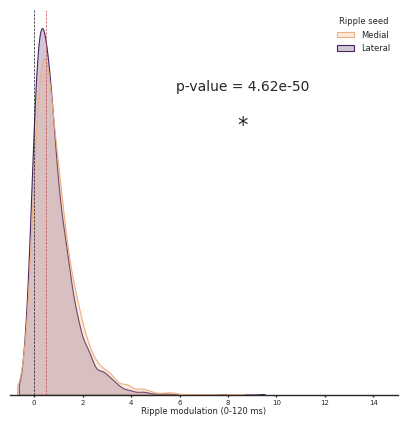

In [551]:
fig, ax0 = plt.subplots(1, figsize=(5,5))
data = _[_['Parent brain region']=='HPF']
param = 'Ripple modulation (0-120 ms)'
plot_dist_ripple_mod(data, param, ax0)

mwu p-val and CLES:  5.187062035969835e-32 0.4614799205419412

mwu p-val and CLES:  4.457510482224396e-258 0.691014657604026

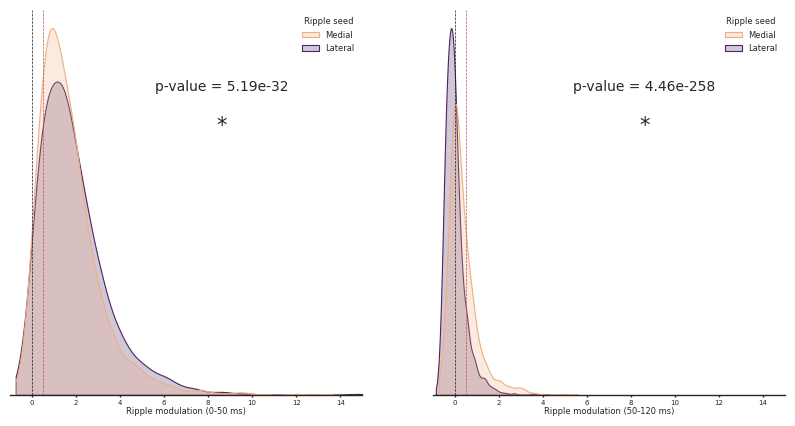

In [552]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

_ = summary_units_df_sub[(summary_units_df_sub['Firing rate (0-50 ms) medial']>minimum_firing_rate_hz) |
                                                        (summary_units_df_sub['Firing rate (0-50 ms) lateral']>minimum_firing_rate_hz)][['Ripple modulation (0-50 ms) medial', 'Ripple modulation (0-50 ms) lateral', 'Parent brain region']]

_ = pd.wide_to_long(_.reset_index(), stubnames='Ripple modulation (0-50 ms)', i=['Parent brain region','unit_id'], j="Ripple seed", sep=' ', suffix=r'\w+').reset_index()
_['Ripple seed'] = _["Ripple seed"].str.capitalize()

data = _[_['Parent brain region']=='HPF']
param = 'Ripple modulation (0-50 ms)'
plot_dist_ripple_mod(data, param, axs[0])

_ = summary_units_df_sub[(summary_units_df_sub['Firing rate (0-50 ms) medial']>minimum_firing_rate_hz) |
                                                        (summary_units_df_sub['Firing rate (0-50 ms) lateral']>minimum_firing_rate_hz)][['Ripple modulation (50-120 ms) medial', 'Ripple modulation (50-120 ms) lateral', 'Parent brain region']]

_ = pd.wide_to_long(_.reset_index(), stubnames='Ripple modulation (50-120 ms)', i=['Parent brain region','unit_id'], j="Ripple seed", sep=' ', suffix=r'\w+').reset_index()
_['Ripple seed'] = _["Ripple seed"].str.capitalize()

data = _[_['Parent brain region']=='HPF']
param = 'Ripple modulation (50-120 ms)'
plot_dist_ripple_mod(data, param, axs[1])

In [548]:
_

,Parent brain region,unit_id,Ripple seed,Ripple modulation (50-120 ms)
0,MB,951171083,Medial,-0.062428
1,MB,951171083,Lateral,-0.066261
2,MB,951171091,Medial,-0.050967
3,MB,951171091,Lateral,-0.059812
4,MB,951171137,Medial,0.241379
...,...,...,...,...
9333,Isocortex,950956148,Lateral,0.035335
9334,Isocortex,950956778,Medial,0.107459
9335,Isocortex,950956778,Lateral,-0.022052
9336,Isocortex,950956952,Medial,0.050491


In [553]:
def func_annotate(data, **kws):
    ax0 = plt.gca()
    #print(data["Parent brain region"].unique())
    norm_test =pg.normality(data=data, dv=param, group="Ripple seed")
    
    if norm_test["normal"].all():
        p_val = pg.ttest(data[data["Ripple seed"] == "Medial"][param],
               data[data["Ripple seed"] == "Lateral"][param], paired=True)["p-val"][0]
        print("ttest: ", p_val)

    else:
        p_val = pg.wilcoxon(data[data["Ripple seed"]=="Medial"][param], data[data["Ripple seed"]=="Lateral"][param])["p-val"][0]
        cles = pg.wilcoxon(data[data["Ripple seed"]=="Medial"][param], data[data["Ripple seed"]=="Lateral"][param])["CLES"][0]
        print("mwu p-val and CLES: ", p_val, cles)

    if p_val<.05:
        ax0.text(.6, .8, "*",
                    transform=ax0.transAxes,
                    fontsize=15, ha='center', va='center');
        ax0.text(.6, .7,  f"p-value = {'{:.2e}'.format(p_val)}",
                    transform=ax0.transAxes,
                    fontsize=10, ha='center', va='center');
        ax0.text(.6, .6,  f"CLES = {cles}",
                    transform=ax0.transAxes,
                    fontsize=10, ha='center', va='center');
       



mwu p-val and CLES:  3.611424671911141e-34 0.6002731529656608

mwu p-val and CLES:  0.6909872684178435 0.49363190989286043

mwu p-val and CLES:  6.433772439426369e-06 0.5809437822816573

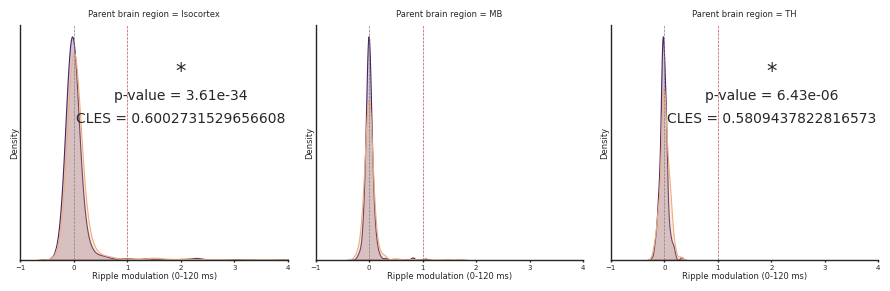

In [554]:
_ = summary_units_df_sub[(summary_units_df_sub['Firing rate (0-50 ms) medial']>minimum_firing_rate_hz) |
                                                        (summary_units_df_sub['Firing rate (0-50 ms) lateral']>minimum_firing_rate_hz)][['Ripple modulation (0-120 ms) medial', 'Ripple modulation (0-120 ms) lateral', 'Parent brain region']]

_ = pd.wide_to_long(_.reset_index(), stubnames='Ripple modulation (0-120 ms)', i=['Parent brain region','unit_id'], j="Ripple seed", sep=' ', suffix=r'\w+').reset_index()
_['Ripple seed'] = _["Ripple seed"].str.capitalize()
param = 'Ripple modulation (0-120 ms)'
g = sns.FacetGrid(_[_['Parent brain region']!='HPF'], col='Parent brain region', sharex=False, sharey=False, col_order=['Isocortex', 'MB', 'TH'])
g.map_dataframe(sns.kdeplot, x='Ripple modulation (0-120 ms)', hue='Ripple seed', palette=palette_ML, fill=True, gridsize=500)
g.refline(x=0)
g.refline(x=1, color='r')
g.set(xlim=(-1, 4))
g.set(yticks=[])
g.map_dataframe(func_annotate)

In [216]:
summary_units_df_sub['Firing rate (0-120 ms)'] = (summary_units_df_sub['Firing rate (0-120 ms) medial']+summary_units_df_sub['Firing rate (0-120 ms) lateral'])/2
summary_units_df_sub['Firing rate (120-0 ms)'] = (summary_units_df_sub['Firing rate (120-0 ms) medial']+summary_units_df_sub['Firing rate (120-0 ms) lateral'])/2
summary_units_df_sub['Firing rate (0-50 ms)'] = (summary_units_df_sub['Firing rate (0-50 ms) medial']+summary_units_df_sub['Firing rate (0-120 ms) lateral'])/2


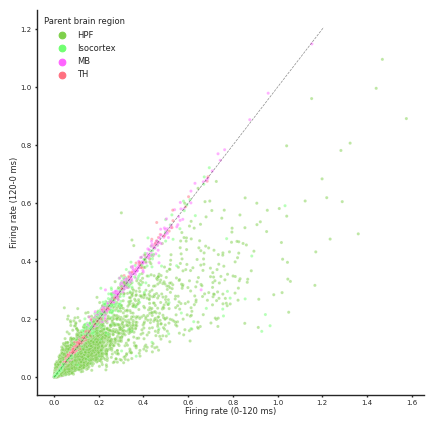

In [217]:
fig, axs = plt.subplots(1, figsize=(5,5))
sns.scatterplot(ax=axs, data=summary_units_df_sub, x='Firing rate (0-120 ms)', y='Firing rate (120-0 ms)', hue='Parent brain region', palette=palette_parent_areas, alpha=.5, s=5,
                hue_order=['HPF', 'Isocortex', 'MB', 'TH'])
axs.plot([0, axs.get_ylim()[1]], [0, axs.get_ylim()[1]],  alpha=.5, linestyle='--', color='k')

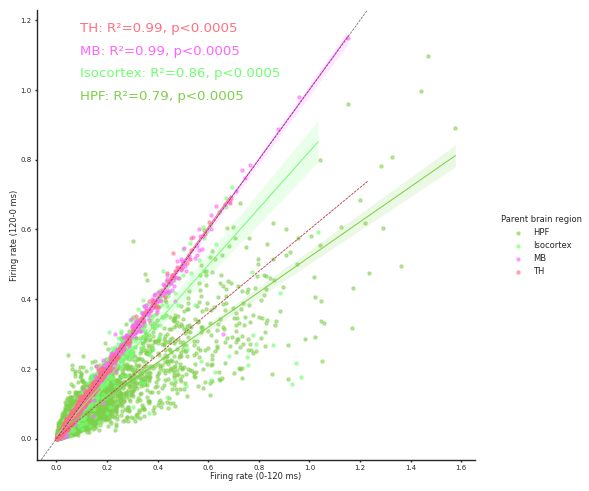

In [296]:
import scipy as sp

g = sns.lmplot( data=summary_units_df_sub, x='Firing rate (0-120 ms)', y='Firing rate (120-0 ms)', hue='Parent brain region', 
           palette=palette_parent_areas, scatter_kws=dict( alpha=.5, s=5),
                hue_order=['HPF', 'Isocortex', 'MB', 'TH'], height=5, aspect=1)

yg = {'HPF':.8, 'Isocortex':.85, 'MB':.9, 'TH':.95}

def annotate(data, **kws):
    
    g = data['Parent brain region'].unique()[0]

    # get the y-position from the dict
    y = yg[g]

    r, p = sp.stats.pearsonr(data['Firing rate (0-120 ms)'], data['Firing rate (120-0 ms)'])
    ax = plt.gca()
    if p==0:
        ax.text(.1, y, f"{g}: R²={r**2:.2f}, p<0.0005", transform = ax.transAxes, color=palette_parent_areas[g])
    else:  
        ax.text(.1, y, f"{g}: R²={r**2:.2f}, p={2:.2e}", transform = ax.transAxes, color=palette_parent_areas[g])
    
g.map_dataframe(annotate)
g.map_dataframe(lambda data, **kws: plt.axline((0, 0), slope=1,  alpha=.2, linestyle='--', color='k'))

def plot_diag(data, **kws):
    ax = plt.gca()
    ax.plot([0, ax.get_ylim()[1]], [0, ax.get_ylim()[1]/(5/3)],  alpha=.5, linestyle='--', color='r')
    #ax.plot([0, ax.get_ylim()[1]/(5/3)], [0, ax.get_ylim()[1]],  alpha=.5, linestyle='--', color='r')
    
g.map_dataframe(plot_diag)

In [294]:
5/3

1.6666666666666667

Text(0.5, 1.0, 'firing rate post-ripple start')

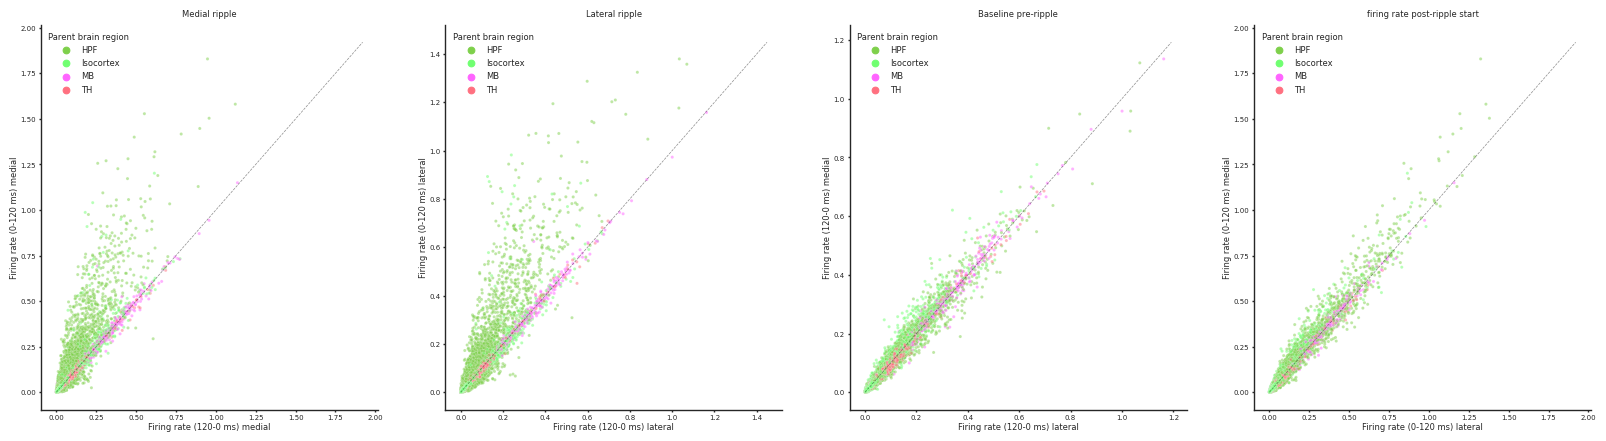

In [159]:
fig, axs = plt.subplots(1,4, figsize=(20,5))
sns.scatterplot(ax=axs[0], data=summary_units_df_sub, x='Firing rate (120-0 ms) medial', y='Firing rate (0-50 ms) medial', hue='Parent brain region', 
                palette=palette_parent_areas, alpha=.5, s=5, 
                hue_order=['HPF', 'Isocortex', 'MB', 'TH'])
axs[0].plot([0, axs[0].get_ylim()[1]], [0, axs[0].get_ylim()[1]],  alpha=.5, linestyle='--', color='k')
axs[0].set_title("Medial ripple")
sns.scatterplot(ax=axs[1], data=summary_units_df_sub, x='Firing rate (120-0 ms) lateral', y='Firing rate (0-120 ms) lateral', hue='Parent brain region', palette=palette_parent_areas, alpha=.5, s=5,  hue_order=['HPF', 'Isocortex', 'MB', 'TH']
               )
axs[1].plot([0, axs[1].get_ylim()[1]], [0, axs[1].get_ylim()[1]],  alpha=.5, linestyle='--', color='k')
axs[1].set_title("Lateral ripple")


sns.scatterplot(ax=axs[2], data=summary_units_df_sub, y='Firing rate (120-0 ms) medial', x='Firing rate (120-0 ms) lateral', hue='Parent brain region', palette=palette_parent_areas, alpha=.5, s=5,  hue_order=['HPF', 'Isocortex', 'MB', 'TH']
               )
axs[2].plot([0, axs[2].get_ylim()[1]], [0, axs[2].get_ylim()[1]],  alpha=.5, linestyle='--', color='k')
axs[2].set_title("Baseline pre-ripple")

sns.scatterplot(ax=axs[3], data=summary_units_df_sub, y="Firing rate (0-50 ms) medial", x="Firing rate (0-120 ms) lateral", hue='Parent brain region', palette=palette_parent_areas, alpha=.5, s=5,  hue_order=['HPF', 'Isocortex', 'MB', 'TH']
               )
axs[3].plot([0, axs[3].get_ylim()[1]], [0, axs[3].get_ylim()[1]],  alpha=.5, linestyle='--', color='k')
axs[3].set_title("firing rate post-ripple start")

In [247]:
summary_units_df_sub[['Ripple modulation (0-120 ms) medial', 'Ripple modulation (0-120 ms) lateral']].corr()**2

,Ripple modulation (0-120 ms) medial,Ripple modulation (0-120 ms) lateral
Ripple modulation (0-120 ms) medial,1.000000,0.486246
Ripple modulation (0-120 ms) lateral,0.486246,1.000000


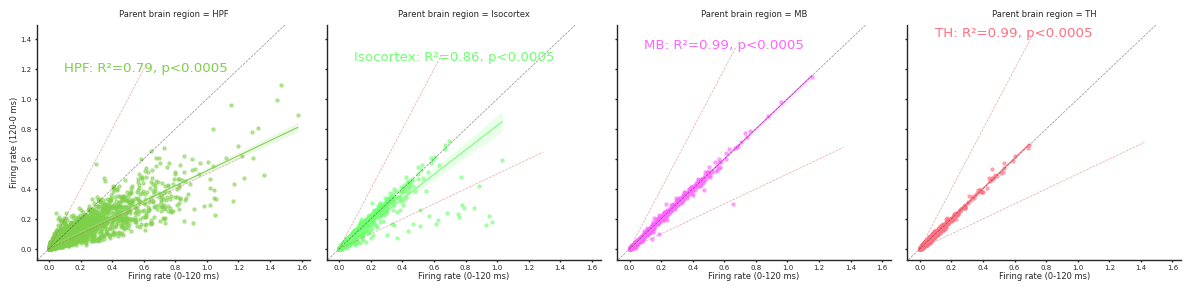

In [166]:
g = sns.FacetGrid(summary_units_df_sub, col='Parent brain region', hue='Parent brain region', palette=palette_parent_areas, col_order=['HPF', 'Isocortex', 'MB', 'TH'])
g.map_dataframe(sns.regplot, x='Firing rate (0-120 ms)', y='Firing rate (120-0 ms)', scatter_kws=dict(s=5, alpha=.5))
g.map_dataframe(lambda data, **kws: plt.axline((0, 0), slope=1,  alpha=.5, linestyle='--', color='k'))

def annotate(data, **kws):
    
    g = data['Parent brain region'].unique()[0]

    # get the y-position from the dict
    y = yg[g]

    r, p = sp.stats.pearsonr(data['Firing rate (0-120 ms)'], data['Firing rate (120-0 ms)'])
    ax = plt.gca()
    if p==0:
        ax.text(.1, y, f"{g}: R²={r**2:.2f}, p<0.0005", transform = ax.transAxes, color=palette_parent_areas[g])
    else:  
        ax.text(.1, y, f"{g}: R²={r**2:.2f}, p={2:.2e}", transform = ax.transAxes, color=palette_parent_areas[g])
    
g.map_dataframe(annotate)

def plot_diag(data, **kws):
    ax = plt.gca()
    ax.plot([0, ax.get_ylim()[1]], [0, ax.get_ylim()[1]/2],  alpha=.5, linestyle='--', color='r')
    ax.plot([0, ax.get_ylim()[1]/2], [0, ax.get_ylim()[1]],  alpha=.5, linestyle='--', color='r')
    
g.map_dataframe(plot_diag)

In [63]:
PROPS = {
    'medianprops':{'color':'white'},
}


In [64]:
palette_HPF = {'DG':'#2292A4', 'CA3':'#FF4365', 'CA1':'#754668', 'ProS':'#EAC435', 'SUB':'#04080F'}

In [65]:
def point_plot_modulation_ripples(data, dv, parent_area, order, filter_spiking, axs, ylabel, ylim = [-.5,2] , palette=palette_HPF):

    _ = data[(filter_spiking) & (data['Parent brain region']==parent_area )].reset_index()[['Firing rate','unit_id','M-L',
                                                                                            'Session id', 'Brain region', dv + ' medial', dv + ' lateral']]
    _ = pd.wide_to_long(_.reset_index(), stubnames=dv, i=['Brain region','index'], j='Type', sep=' ', suffix=r'\w+').reset_index()
    _['Type'] = _['Type'].str.capitalize()


    ax = sns.pointplot(data=_, x='Brain region', y=dv, hue='Type', dodge=.5, errorbar='se',join=False,  palette=palette_ML, ax=axs, capsize=.2, order=order)
    ax.axhline(0,color= 'k', linestyle='--')
    color_to_labels_custom_palette(ax, 'x', 'major', palette, 1)
    plt.xticks(rotation=45, ha='center')
    ax.set_ylim(ylim)
    ax.set_ylabel(ylabel)

    stat = []
    for area in _['Brain region'].unique():
        sub = _[_['Brain region']==area]
       
        if pg.normality(sub, group='Type', dv=dv)['normal'].all():
            test = pg.ttest(sub[sub['Type']=='Medial'][dv], sub[sub['Type']=='Lateral'][dv])['p-val']
        else:
            test = pg.wilcoxon(sub[sub['Type']=='Medial'][dv], sub[sub['Type']=='Lateral'][dv])['p-val']
        
        if test[0] < .05:
            stat.append(((area, 'Medial'), (area, 'Lateral')))
            #print(area,pg.ttest(sub[sub['Type']=='Medial'][dv], sub[sub['Type']=='Lateral'][dv], paired=True))
            #print( pg.wilcoxon(sub[sub['Type']=='Medial'][dv], sub[sub['Type']=='Lateral'][dv]))

    if len(stat)>0:
        annot = Annotator(ax, data=_, pairs= stat,
                           x='Brain region', y=dv, hue='Type', order=order)
        (annot
         .configure(test=None, test_short_name='custom test',  text_format='star', loc='inside', verbose=0)
         .set_pvalues(pvalues=[.3]*len(stat))
         .set_custom_annotations(['*']*len(stat))
         .annotate());
#axs[1].text(.6, .7, 'Cohen's d: ' + str(round(ttest_late_spiking['cohen-d'].values[0], 2)), transform=axs[1].transAxes,fontsize=6, ha='center', va='center');

## ripple mod per area

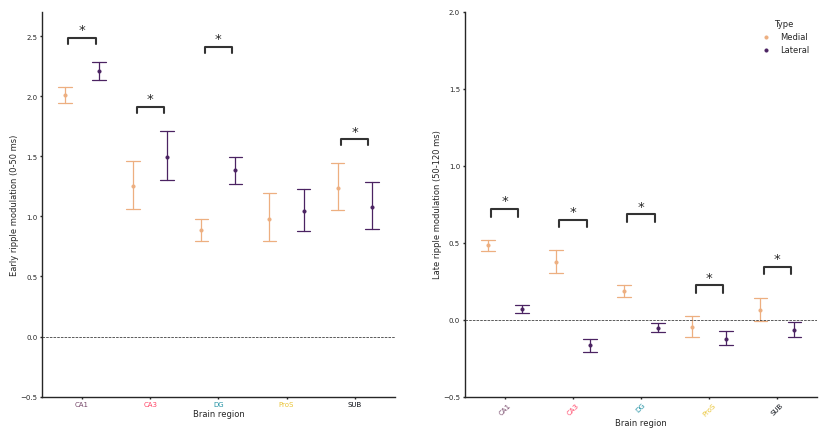

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

minimum_firing_rate_hz = .1

parent_area='HPF'
order= ['CA1',  'CA3', 'DG', 'ProS', 'SUB']

dv = 'Ripple modulation (0-50 ms)'
ylabel = 'Early ripple modulation (0-50 ms)'
filter_spiking = (summary_units_df_sub['Firing rate (0-50 ms) medial']>minimum_firing_rate_hz) |\
                                                        (summary_units_df_sub['Firing rate (0-50 ms) lateral']>minimum_firing_rate_hz)
point_plot_modulation_ripples(summary_units_df_sub, dv, parent_area, order,filter_spiking,axs[0], ylabel)
axs[0].get_legend().remove()
dv = 'Ripple modulation (50-120 ms)'
ylabel = 'Late ripple modulation (50-120 ms)'
point_plot_modulation_ripples(summary_units_df_sub, dv,parent_area, order, filter_spiking,axs[1], ylabel)



In [518]:
palette_areas = dict()
for area in summary_units_df_sub['Brain region'].unique():
    palette_areas[area] = '#' + ''.join(f'{i:02X}' for i in acronym_color_map[area]);

In [538]:
data = summary_units_df_sub

parent_area='TH'
_ = data[(filter_spiking) & (data['Parent brain region']==parent_area )].reset_index()[['Firing rate','unit_id','M-L',
                                                                                        'Session id', 'Brain region', dv + ' medial', dv + ' lateral']]
_ = pd.wide_to_long(_.reset_index(), stubnames=dv, i=['Brain region','index'], j='Type', sep=' ', suffix=r'\w+').reset_index()
_['Type'] = _['Type'].str.capitalize()

In [539]:
_

,Brain region,index,Type,Session id,unit_id,Firing rate,M-L,Pre-ripple modulation
0,LP,0,Medial,839068429,951175428,14.874967,2149.48999,-0.194444
1,LP,0,Lateral,839068429,951175428,14.874967,2149.48999,-0.238579
2,LP,1,Medial,839068429,951175442,15.059564,2161.48999,-0.050633
3,LP,1,Lateral,839068429,951175442,15.059564,2161.48999,-0.119318
4,LP,2,Medial,839068429,951175465,11.686312,2169.48999,-0.290780
...,...,...,...,...,...,...,...,...
821,LGd,410,Lateral,715093703,950947798,15.528117,2011.48999,0.256906
822,LGd,411,Medial,715093703,950948139,16.876319,2067.48999,-0.083969
823,LGd,411,Lateral,715093703,950948139,16.876319,2067.48999,-0.069767
824,LGd,412,Medial,715093703,950948371,18.735682,2099.48999,0.048110


In [498]:
sub = _[_['Brain region']=="VISpm"]
dv = 'Ripple modulation (0-50 ms)'

In [499]:
sub.groupby("Type").sem()

,index,Session id,unit_id,Firing rate,M-L,Ripple modulation (0-50 ms)
Type,,,,,,
Lateral,39.207865,3.079286e+06,32301.327155,0.912043,21.188337,0.057439
Medial,39.207865,3.079286e+06,32301.327155,0.912043,21.188337,0.040829


In [500]:
sub.groupby("Type").mean()

,index,Session id,unit_id,Firing rate,M-L,Ripple modulation (0-50 ms)
Type,,,,,,
Lateral,605.095745,7.851682e+08,9.511775e+08,14.327047,1833.567768,0.087851
Medial,605.095745,7.851682e+08,9.511775e+08,14.327047,1833.567768,0.094452


In [502]:
pg.ttest(sub[sub['Type']=='Medial'][dv], sub[sub['Type']=='Lateral'][dv])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.093667,186,two-sided,0.925474,"[-0.13, 0.15]",0.013663,0.159,0.050995


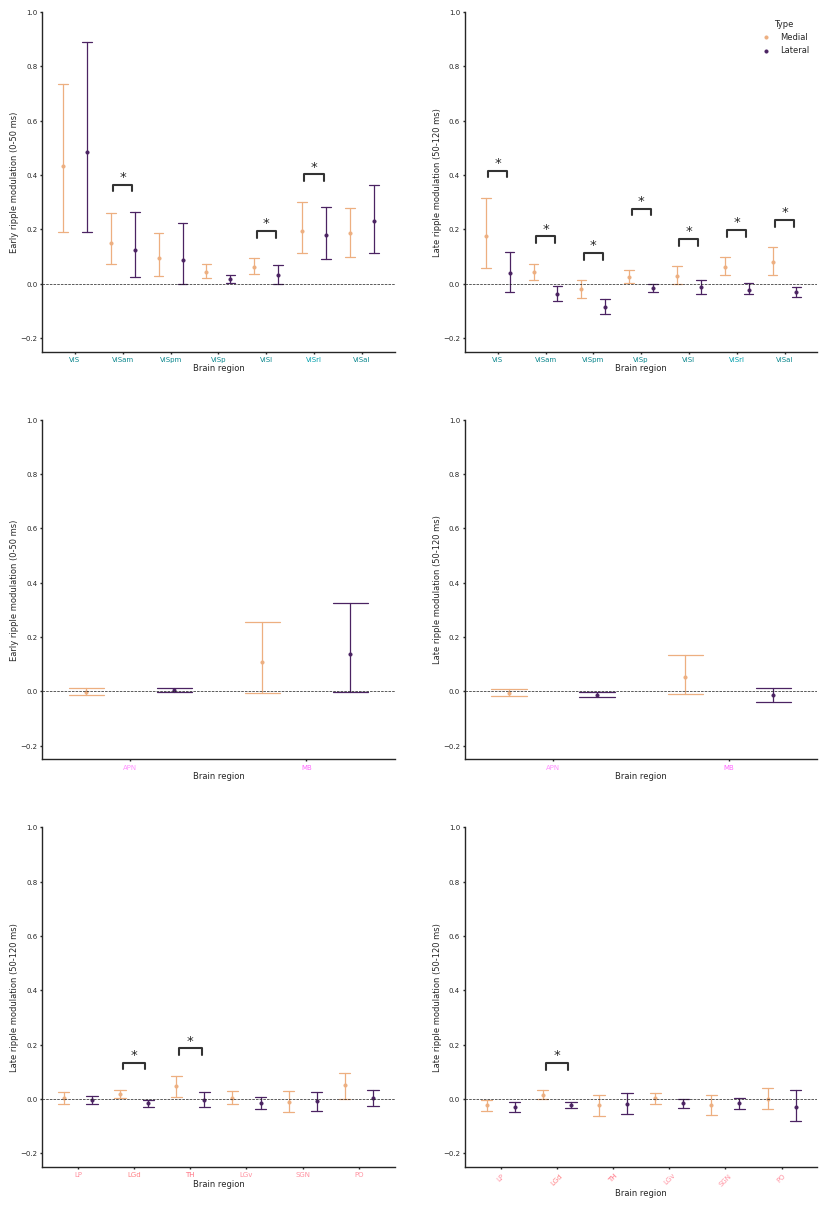

In [530]:
fig, axs = plt.subplots(3, 2, figsize=(10,15))

parent_area='Isocortex'
order= ['VIS', 'VISam', 'VISpm', 'VISp', 'VISl', 'VISrl', 'VISal']
ylim= [-0.25,1]
dv = 'Ripple modulation (0-50 ms)'
ylabel = 'Early ripple modulation (0-50 ms)'
filter_spiking = (summary_units_df_sub['Firing rate (0-50 ms) medial']>minimum_firing_rate_hz) |\
                                                        (summary_units_df_sub['Firing rate (0-50 ms) lateral']>minimum_firing_rate_hz)
point_plot_modulation_ripples(summary_units_df_sub, dv, parent_area, order,filter_spiking,axs[0,0], ylabel,ylim ,palette_areas)
axs[0,0].get_legend().remove()
dv = 'Ripple modulation (50-120 ms)'
ylabel = 'Late ripple modulation (50-120 ms)'
point_plot_modulation_ripples(summary_units_df_sub, dv,parent_area, order, filter_spiking,axs[0,1], ylabel,ylim,  palette_areas)


parent_area='MB'
order= ['APN', 'MB']

dv = 'Ripple modulation (0-50 ms)'
ylabel = 'Early ripple modulation (0-50 ms)'

point_plot_modulation_ripples(summary_units_df_sub, dv, parent_area, order,filter_spiking,axs[1, 0], ylabel,ylim, palette_areas)
axs[1, 0].get_legend().remove()
dv = 'Ripple modulation (50-120 ms)'
ylabel = 'Late ripple modulation (50-120 ms)'
point_plot_modulation_ripples(summary_units_df_sub, dv,parent_area, order, filter_spiking,axs[1, 1], ylabel,ylim, palette_areas)
axs[1, 1].get_legend().remove()


parent_area='TH'
order= ['LP', 'LGd', 'TH', 'LGv', 'SGN', 'PO']

dv = 'Ripple modulation (0-50 ms)'


point_plot_modulation_ripples(summary_units_df_sub, dv, parent_area, order,filter_spiking,axs[2, 0], ylabel,ylim, palette_areas)
axs[2,0].get_legend().remove()
dv = 'Ripple modulation (50-120 ms)'
ylabel = 'Late ripple modulation (50-120 ms)'
point_plot_modulation_ripples(summary_units_df_sub, dv,parent_area, order, filter_spiking,axs[2, 1], ylabel,ylim, palette_areas)
axs[2,1].get_legend().remove()

## preripple mod per area

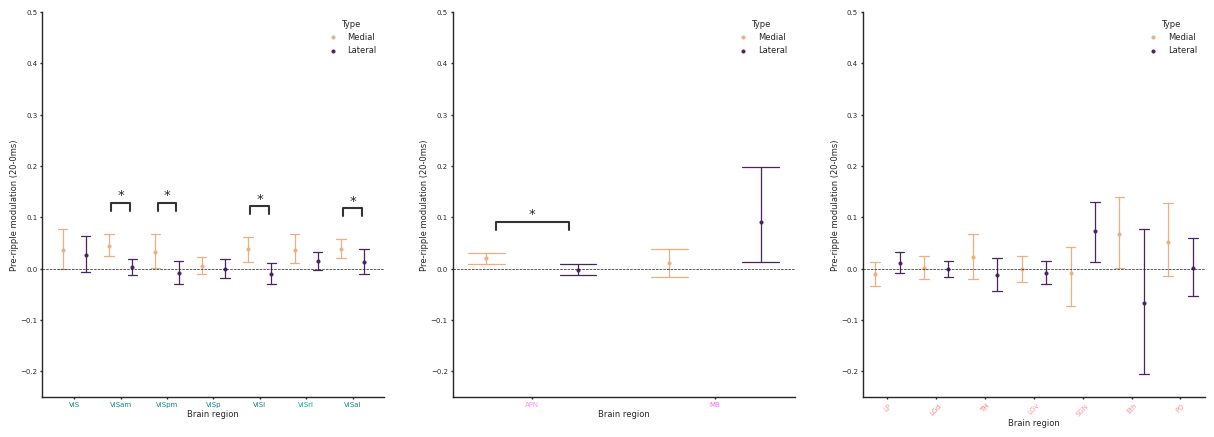

In [542]:
fig, axs = plt.subplots(1,3,  figsize=(15,5))

ylim = [-.25, .5]
parent_area='Isocortex'
order= ['VIS', 'VISam', 'VISpm', 'VISp', 'VISl', 'VISrl', 'VISal']

dv = 'Pre-ripple modulation'
ylabel = 'Pre-ripple modulation (20-0ms)'
filter_spiking = (summary_units_df_sub['Firing rate (0-50 ms) medial']>minimum_firing_rate_hz) |\
                                                        (summary_units_df_sub['Firing rate (0-50 ms) lateral']>minimum_firing_rate_hz)
point_plot_modulation_ripples(summary_units_df_sub, dv, parent_area, order,filter_spiking,axs[0], ylabel,ylim, palette_areas)

parent_area='MB'
order= ['APN', 'MB']

dv = 'Pre-ripple modulation'
ylabel = 'Pre-ripple modulation (20-0ms)'

point_plot_modulation_ripples(summary_units_df_sub, dv, parent_area, order,filter_spiking,axs[1], ylabel, ylim,palette_areas)

parent_area='TH'
order= ['LP', 'LGd', 'TH', 'LGv', 'SGN', 'Eth', 'PO']

dv = 'Pre-ripple modulation'
ylabel='Pre-ripple modulation (20-0ms)'

point_plot_modulation_ripples(summary_units_df_sub, dv, parent_area, order,filter_spiking,axs[2], ylabel, ylim,palette_areas)


In [ ]:
from scipy.stats import pearsonr

In [ ]:
def pearsonr_pval(x,y):
        return pearsonr(x,y)[1]

In [37]:
medial_lim

7772.97056

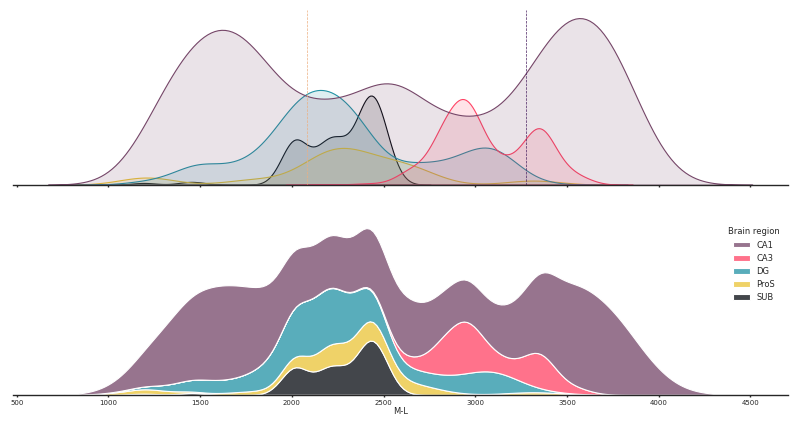

In [38]:
fig, axs = plt.subplots(2, figsize=(10,5), sharex=True)
sns.kdeplot(ax=axs[0], data=summary_units_df_sub[ summary_units_df_sub['Parent brain region']=='HPF'],
            hue='Brain region', x='M-L',  palette=palette_HPF, fill=True,  alpha=.15, hue_order=['CA1',  'CA3', 'DG', 'ProS', 'SUB'], legend=False)
sns.kdeplot(ax=axs[1], data=summary_units_df_sub[ summary_units_df_sub['Parent brain region']=='HPF'],
            hue='Brain region', x='M-L',  palette=palette_HPF, multiple='stack', hue_order=['CA1',  'CA3', 'DG', 'ProS', 'SUB'])
axs[0].get_yaxis().set_visible(False) 
axs[1].get_yaxis().set_visible(False)
axs[0].spines[['left']].set_visible(False)
axs[1].spines[['left']].set_visible(False)
axs[0].axvline(medial_lim - 5691.510009765625,  color= palette_ML["Medial"], linestyle='--')
axs[0].axvline(lateral_lim - 5691.510009765625,  color= palette_ML["Lateral"], linestyle='--')


In [77]:
area = 'ProS'
r_sq_sub=summary_units_df_sub[((summary_units_df_sub['Firing rate (0-50 ms) medial']>minimum_firing_rate_hz) |\
                                                        (summary_units_df_sub['Firing rate (0-50 ms) lateral']>minimum_firing_rate_hz)) & (summary_units_df_sub['Brain region']==area )]\
                                        [["Diff pre-ripple modulation (20-0 ms)", 'Diff firing rate (0-50 ms)' , 'Diff ripple modulation (0-50 ms)',  'Diff ripple modulation (50-120 ms)', 
                                          'Ripple modulation (0-50 ms) medial','Ripple modulation (0-50 ms) lateral', 'M-L',
                                            'A-P', 'D-V']]\
               .corr().loc[["Diff pre-ripple modulation (20-0 ms)", 'Diff ripple modulation (0-50 ms)', 'Diff ripple modulation (50-120 ms)', 'Diff firing rate (0-50 ms)', \
                         'Ripple modulation (0-50 ms) medial','Ripple modulation (0-50 ms) lateral'], ["M-L", "A-P", "D-V"]]**2 *100


In [78]:
r_sq_sub

,M-L,A-P,D-V
Diff pre-ripple modulation (20-0 ms),0.137929,0.404786,7.497802
Diff ripple modulation (0-50 ms),0.553580,0.786497,14.262545
Diff ripple modulation (50-120 ms),4.033135,2.747243,3.641573
Diff firing rate (0-50 ms),0.058280,0.090613,16.591799
Ripple modulation (0-50 ms) medial,1.537377,1.139460,0.379226
Ripple modulation (0-50 ms) lateral,3.539945,3.172759,3.179465


In [559]:
area = 'ProS'
r_sq_sub=summary_units_df_sub[((summary_units_df_sub['Firing rate (0-50 ms) medial']>minimum_firing_rate_hz) |\
                                                        (summary_units_df_sub['Firing rate (0-50 ms) lateral']>minimum_firing_rate_hz)) & (summary_units_df_sub['Brain region']==area )]\
                                        [["Diff pre-ripple modulation (20-0 ms)", 'Diff firing rate (0-50 ms)' , 'Diff ripple modulation (0-50 ms)',  'Diff ripple modulation (50-120 ms)', 
                                          'Ripple modulation (0-50 ms) medial','Ripple modulation (0-50 ms) lateral', 'M-L',
                                            'A-P', 'D-V']]\
               .corr().loc[["Diff pre-ripple modulation (20-0 ms)", 'Diff ripple modulation (0-50 ms)', 'Diff ripple modulation (50-120 ms)', 'Diff firing rate (0-50 ms)', \
                         'Ripple modulation (0-50 ms) medial','Ripple modulation (0-50 ms) lateral'], ["M-L", "A-P", "D-V"]]**2

round(r_sq_sub.loc["Diff pre-ripple modulation (20-0 ms)", "M-L"]*100, 2)

0.11

In [41]:
summary_units_df_sub[(summary_units_df_sub['Firing rate (0-50 ms) medial']>0.025) & (summary_units_df_sub['Brain region']==area )]\
                                        [["Diff pre-ripple modulation (20-0 ms)", 'Diff firing rate (0-50 ms)' , 'Diff ripple modulation (0-50 ms)',  'Diff ripple modulation (50-120 ms)', 
                                          'Ripple modulation (0-50 ms) medial','Ripple modulation (0-50 ms) lateral', 'M-L',
                                            'A-P', 'D-V']]\
.corr(method=pearsonr_pval)[["Diff pre-ripple modulation (20-0 ms)", 'Diff ripple modulation (0-50 ms)', 'Diff ripple modulation (50-120 ms)', 'Diff firing rate (0-50 ms)', \
                         'Ripple modulation (0-50 ms) medial','Ripple modulation (0-50 ms) lateral']]

,Diff pre-ripple modulation (20-0 ms),Diff ripple modulation (0-50 ms),Diff ripple modulation (50-120 ms),Diff firing rate (0-50 ms),Ripple modulation (0-50 ms) medial,Ripple modulation (0-50 ms) lateral
Diff pre-ripple modulation (20-0 ms),1.000000e+00,8.870738e-09,3.643178e-30,1.636337e-82,1.957983e-06,8.446902e-01
Diff firing rate (0-50 ms),1.636337e-82,3.857934e-59,9.728623e-36,1.000000e+00,1.684027e-07,5.396606e-12
Diff ripple modulation (0-50 ms),8.870738e-09,1.000000e+00,5.180710e-56,3.857934e-59,1.562493e-09,1.820886e-251
Diff ripple modulation (50-120 ms),3.643178e-30,5.180710e-56,1.000000e+00,9.728623e-36,4.770532e-88,3.811468e-06
Ripple modulation (0-50 ms) medial,1.957983e-06,1.562493e-09,4.770532e-88,1.684027e-07,1.000000e+00,0.000000e+00
Ripple modulation (0-50 ms) lateral,8.446902e-01,1.820886e-251,3.811468e-06,5.396606e-12,0.000000e+00,1.000000e+00
M-L,4.695739e-80,1.896729e-55,1.524744e-77,4.285972e-131,9.729177e-02,3.072910e-21
A-P,4.179715e-26,1.441895e-21,9.803233e-18,8.226574e-40,3.175095e-08,2.903218e-02
D-V,6.785770e-76,4.886404e-43,1.295956e-46,4.685809e-120,2.827718e-11,3.691708e-05


## individual neurons, are some neurons responding only to one direction?

In [258]:
palette_ML['Lateral ripple engagement'] = (0.29408557, 0.13721193, 0.38442775)
palette_ML['Medial ripple engagement'] = (0.92891402, 0.68494686, 0.50173994)
palette_ML['No preference'] = (0.8,.8,.8)


(0.0, 20.0)

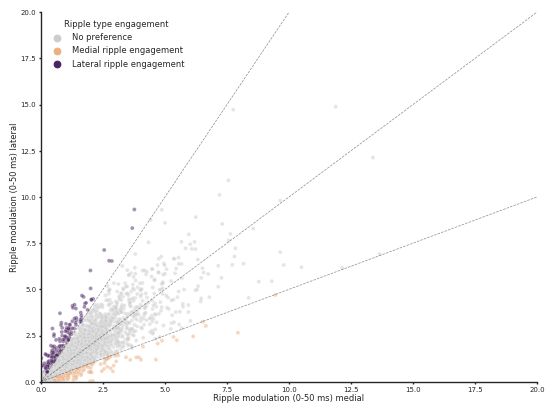

In [259]:
fig, axs = plt.subplots(1)
sns.scatterplot(data=summary_units_df_sub[(summary_units_df_sub['Firing rate (0-120 ms) medial']>0.025)& (summary_units_df_sub['Parent brain region']=='HPF')],\
               x='Ripple modulation (0-50 ms) medial', y= 'Ripple modulation (0-50 ms) lateral', \
                alpha=.5, ax=axs, s=8, hue='Ripple type engagement', palette=palette_ML)
axs.plot([0, axs.get_ylim()[1]], [0, axs.get_ylim()[1]],  alpha=.5, linestyle='--', color='k')
axs.plot([0, axs.get_ylim()[1]], [0, axs.get_ylim()[1]/2],  alpha=.5, linestyle='--', color='k')
axs.plot([0, axs.get_ylim()[1]/2], [0, axs.get_ylim()[1]],  alpha=.5, linestyle='--', color='k')
axs.set_xlim((0,20))
axs.set_ylim((0,20))

<AxesSubplot:ylabel='Ripple type engagement'>

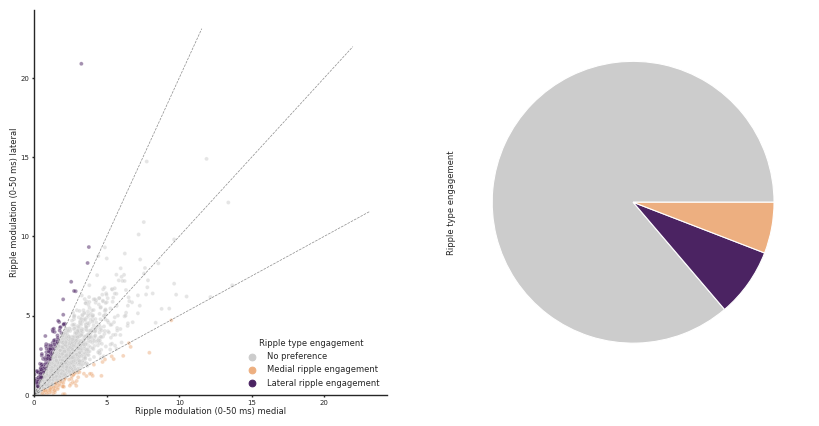

In [260]:
fig, axs = plt.subplots(1,2,  figsize=(10,5))
sns.scatterplot(data=summary_units_df_sub[(summary_units_df_sub['Firing rate (0-120 ms) medial']>0.025)& (summary_units_df_sub['Parent brain region']=='HPF' )],
               x='Ripple modulation (0-50 ms) medial', y= 'Ripple modulation (0-50 ms) lateral', alpha=.5, ax=axs[0], s=8, hue='Ripple type engagement', palette=palette_ML)
axs[0].plot([0, axs[0].get_ylim()[1]], [0, axs[0].get_ylim()[1]],  alpha=.5, linestyle='--', color='k')
axs[0].plot([0, axs[0].get_ylim()[1]], [0, axs[0].get_ylim()[1]/2],  alpha=.5, linestyle='--', color='k')
axs[0].plot([0, axs[0].get_ylim()[1]/2], [0, axs[0].get_ylim()[1]],  alpha=.5, linestyle='--', color='k')
axs[0].set_xlim((0,axs[0].get_xlim()[1]))
axs[0].set_ylim((0,axs[0].get_ylim()[1]))

_ = pd.DataFrame(summary_units_df_sub[(summary_units_df_sub['Firing rate (0-120 ms) medial']>0.025)& 
                     (summary_units_df_sub['Parent brain region']=='HPF' )]['Ripple type engagement'].value_counts())

_.plot.pie(y= 'Ripple type engagement', ax=axs[1], colors=[palette_ML[key] for key in _.index], labels=None, legend=False)

Text(0.5, 1.0, 'Ripple type engagement')

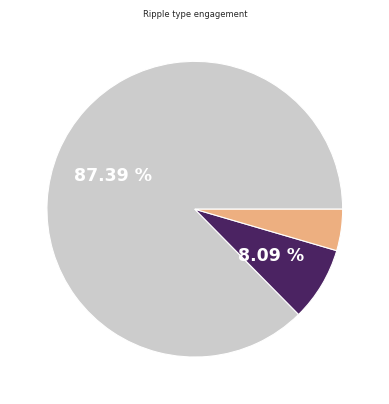

In [556]:
_ = pd.DataFrame(summary_units_df_sub[(summary_units_df_sub['Firing rate (0-120 ms) medial']>0.1)& 
                     (summary_units_df_sub['Parent brain region']=='HPF' )]['Ripple type engagement'].value_counts())

def my_autopct(pct):
    return ('%.2f'  % pct + " %") if pct > 5 else ''

fig, ax = plt.subplots()
_, _, autopcts = ax.pie(_.values.squeeze(),colors=[palette_ML[key] for key in _.index], autopct=my_autopct)

plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':12.5})

ax.xaxis.set_label_position('top')
ax.set_title('Ripple type engagement')


In [316]:
data = pd.DataFrame(summary_units_df_sub[(summary_units_df_sub['Firing rate (0-120 ms) medial']>0.025)& 
                     (summary_units_df_sub['Parent brain region']=='HPF' )].groupby('Brain region')['Ripple type engagement'].value_counts())

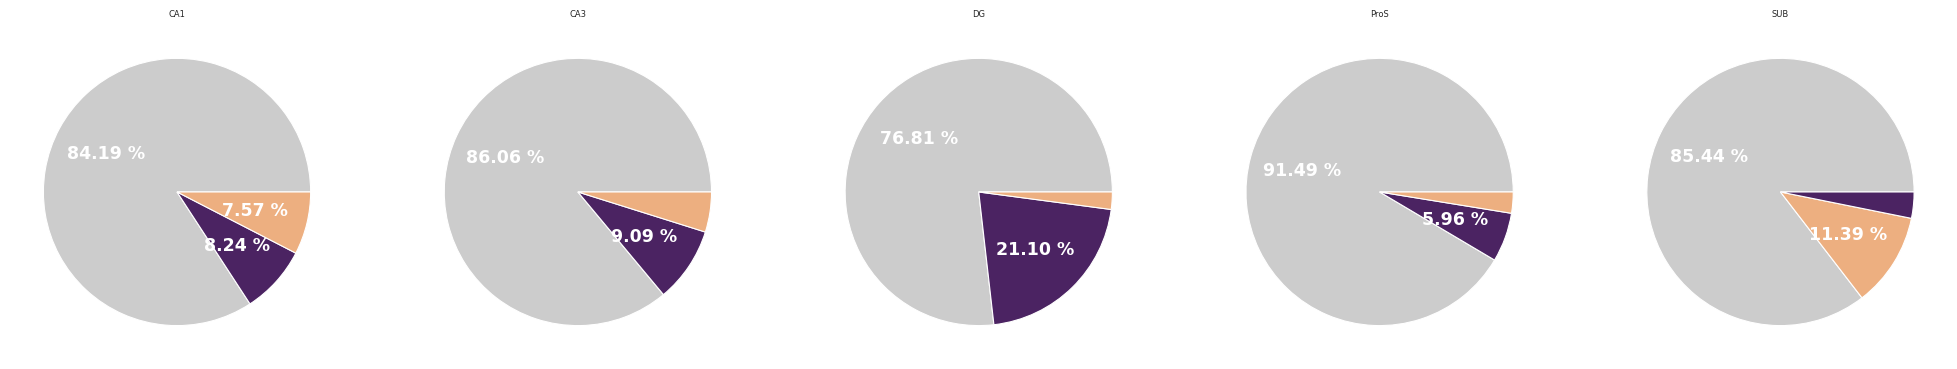

In [318]:
fig, axs = plt.subplots(1,5, figsize=(25,20))
axs = axs.ravel()

def my_autopct(pct):
    return ('%.2f'  % pct + " %") if pct > 5 else ''


for q, area in zip(range(5), data.index.get_level_values('Brain region').unique()):

    _, _, autopcts = axs[q].pie(data.loc[area].values.squeeze(), colors=[palette_ML[key] for key in data.loc[area].index], autopct=my_autopct)

    plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':12.5})

    axs[q].xaxis.set_label_position('top')
    axs[q].set_title(area)

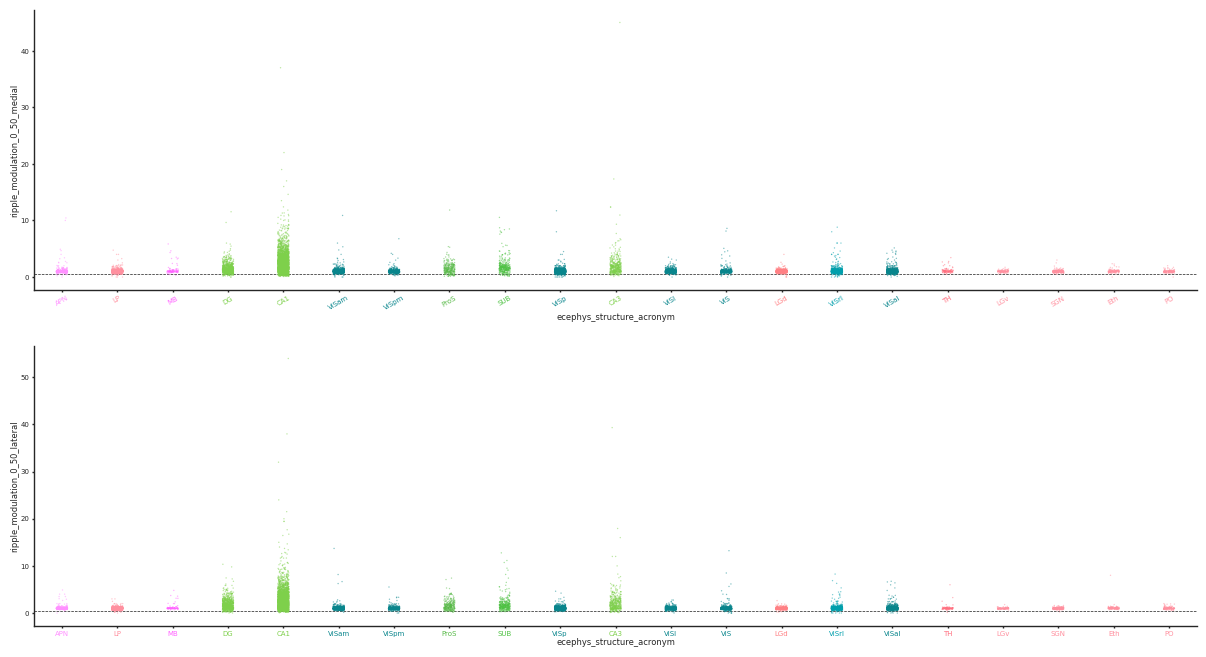

In [35]:
fig, axs = plt.subplots( 2, figsize=(15,8))
axs[0].axhline(.5, color= 'k', linestyle='--')
sns.stripplot(data=summary_units_df_sub, y='Ripple modulation (0-50 ms) medial', x='Brain region', palette=palette_areas, alpha=.5, s=1, ax=axs[0])
color_to_labels(axs[0], 'x', 'major', 1);
sns.stripplot(data=summary_units_df_sub, y='Ripple modulation (0-50 ms) lateral', x='Brain region', palette=palette_areas, alpha=.5, s=1, ax=axs[1])
color_to_labels(axs[1], 'x', 'major', 1);
axs[1].axhline(.5,color= 'k', linestyle='--')

props = {'rotation' : 30}
plt.setp(axs[0].get_xticklabels(), **props);
plt.setp(axs[0].get_xticklabels(), **props);

In [116]:
parent_area = "HPF"
for param in summary_units_df_sub.columns:
    
    try:
        p_val =  pg.ttest(summary_units_df_sub[(summary_units_df_sub["Parent brain region"]==parent_area) &
                                 (summary_units_df_sub["Ripple engagement"]=="Ripple engagement")][param], 
                    summary_units_df_sub[(summary_units_df_sub["Parent brain region"]==parent_area) &
                                 (summary_units_df_sub["Ripple engagement"]=="No engagement")][param])["p-val"]
        if p_val[0]<.05:
            print(param, p_val)
    except:
        continue

L ratio T-test    7.827320e-16
Name: p-val, dtype: float64

Waveform halfwidth T-test    0.013923
Name: p-val, dtype: float64

Waveform recovery slope T-test    0.000776
Name: p-val, dtype: float64

Peak channel id T-test    0.001083
Name: p-val, dtype: float64

Cluster id T-test    3.264878e-16
Name: p-val, dtype: float64

Waveform duration T-test    6.500508e-10
Name: p-val, dtype: float64

Max drift T-test    0.003054
Name: p-val, dtype: float64

Local index unit T-test    1.346610e-16
Name: p-val, dtype: float64

Firing rate T-test    6.434974e-11
Name: p-val, dtype: float64

Waveform repolarization slope T-test    2.327973e-09
Name: p-val, dtype: float64

Isolation distance T-test    1.987384e-08
Name: p-val, dtype: float64

Waveform spread T-test    5.028694e-07
Name: p-val, dtype: float64

Cumulative drift T-test    1.819419e-08
Name: p-val, dtype: float64

Isi violations T-test    1.092373e-71
Name: p-val, dtype: float64

Waveform velocity below T-test    0.000003
Name: p-val, dtype: float64

Presence ratio T-test    0.006987
Name: p-val, dtype: float64

Nn hit rate T-test    4.477085e-15
Name: p-val, dtype: float64

Waveform amplitude T-test    6.005857e-10
Name: p-val, dtype: float64

Area rf T-test    0.000698
Name: p-val, dtype: float64

Fano dg T-test    2.053718e-17
Name: p-val, dtype: float64

Fano dm T-test    0.002673
Name: p-val, dtype: float64

Fano fl T-test    1.808915e-24
Name: p-val, dtype: float64

Fano rf T-test    1.701771e-16
Name: p-val, dtype: float64

F1 f0 dg T-test    3.478710e-68
Name: p-val, dtype: float64

G dsi dg T-test    2.149721e-11
Name: p-val, dtype: float64

G osi dg T-test    1.270998e-09
Name: p-val, dtype: float64

Mod idx dg T-test    0.005299
Name: p-val, dtype: float64

Run mod dg T-test    1.593210e-13
Name: p-val, dtype: float64

Run mod dm T-test    0.000519
Name: p-val, dtype: float64

Run mod fl T-test    0.008017
Name: p-val, dtype: float64

Run pval dm T-test    0.005206
Name: p-val, dtype: float64

Firing rate dg T-test    3.667838e-11
Name: p-val, dtype: float64

Firing rate dm T-test    0.000119
Name: p-val, dtype: float64

Firing rate fl T-test    4.201361e-09
Name: p-val, dtype: float64

Firing rate rf T-test    6.770163e-08
Name: p-val, dtype: float64

Lifetime sparseness dg T-test    5.118507e-16
Name: p-val, dtype: float64

Lifetime sparseness dm T-test    0.002673
Name: p-val, dtype: float64

Lifetime sparseness fl T-test    3.845230e-12
Name: p-val, dtype: float64

Lifetime sparseness rf T-test    7.735747e-45
Name: p-val, dtype: float64

Probe vertical position T-test    5.783650e-40
Name: p-val, dtype: float64

Probe id T-test    0.004988
Name: p-val, dtype: float64

Channel local index T-test    6.832375e-40
Name: p-val, dtype: float64

Ecephys structure id T-test    4.351715e-17
Name: p-val, dtype: float64

A-P T-test    2.622300e-25
Name: p-val, dtype: float64

D-V T-test    8.234165e-07
Name: p-val, dtype: float64

L-R T-test    1.706926e-09
Name: p-val, dtype: float64

Probe sampling rate T-test    0.000003
Name: p-val, dtype: float64

Probe lfp sampling rate T-test    0.000003
Name: p-val, dtype: float64

Probe has lfp data T-test    2.713045e-09
Name: p-val, dtype: float64

Firing rate (0-120 ms) medial T-test    4.925482e-64
Name: p-val, dtype: float64

Firing rate (0-50 ms) medial T-test    3.292751e-91
Name: p-val, dtype: float64

Firing rate (50-120 ms) medial T-test    1.938077e-31
Name: p-val, dtype: float64

Firing rate (100-0 ms) medial T-test    0.008128
Name: p-val, dtype: float64

Firing rate (50-0 ms) medial T-test    0.00123
Name: p-val, dtype: float64

Firing rate (100-20 ms) medial T-test    0.000536
Name: p-val, dtype: float64

Firing rate (0-120 ms) lateral T-test    3.452498e-59
Name: p-val, dtype: float64

Firing rate (0-50 ms) lateral T-test    9.388031e-105
Name: p-val, dtype: float64

Firing rate (50-120 ms) lateral T-test    0.000104
Name: p-val, dtype: float64

Firing rate (100-0 ms) lateral T-test    0.036828
Name: p-val, dtype: float64

Firing rate (20-0 ms) lateral T-test    0.001975
Name: p-val, dtype: float64

Firing rate (100-20 ms) lateral T-test    0.000143
Name: p-val, dtype: float64

Session id T-test    0.004581
Name: p-val, dtype: float64

Fano ns T-test    0.000971
Name: p-val, dtype: float64

G osi sg T-test    0.000251
Name: p-val, dtype: float64

Run mod ns T-test    0.000394
Name: p-val, dtype: float64

Run mod sg T-test    0.006801
Name: p-val, dtype: float64

Pref phase sg T-test    0.009631
Name: p-val, dtype: float64

Firing rate ns T-test    0.004293
Name: p-val, dtype: float64

Firing rate sg T-test    0.005069
Name: p-val, dtype: float64

Image selectivity ns T-test    0.009489
Name: p-val, dtype: float64

Lifetime sparseness ns T-test    0.000039
Name: p-val, dtype: float64

Lifetime sparseness sg T-test    0.000003
Name: p-val, dtype: float64

/alzheimer/Roberto/Software/mambaforge/envs/De-Filippo-et-al-2022/lib/python3.7/site-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


Ripple modulation (0-50 ms) medial T-test    0.0
Name: p-val, dtype: float64

Ripple modulation (0-50 ms) lateral T-test    0.0
Name: p-val, dtype: float64

Ripple modulation (50-120 ms) medial T-test    3.747065e-240
Name: p-val, dtype: float64

Ripple modulation (50-120 ms) lateral T-test    5.674723e-60
Name: p-val, dtype: float64

Ripple modulation (0-120 ms) medial T-test    0.0
Name: p-val, dtype: float64

Ripple modulation (0-120 ms) lateral T-test    0.0
Name: p-val, dtype: float64

Pre-ripple modulation medial T-test    1.593341e-30
Name: p-val, dtype: float64

Pre-ripple modulation lateral T-test    2.620655e-59
Name: p-val, dtype: float64

M-L T-test    1.706926e-09
Name: p-val, dtype: float64

Diff pre-ripple modulation (20-0 ms) T-test    1.425428e-10
Name: p-val, dtype: float64

Diff ripple modulation (0-50 ms) T-test    9.616160e-18
Name: p-val, dtype: float64

Diff ripple modulation (50-120 ms) T-test    4.563691e-127
Name: p-val, dtype: float64

Diff firing rate (0-50 ms) T-test    1.472574e-20
Name: p-val, dtype: float64

Diff firing rate (50-120 ms) T-test    1.297232e-118
Name: p-val, dtype: float64

Firing rate (0-120 ms) T-test    2.131097e-62
Name: p-val, dtype: float64

Firing rate (100-0 ms) T-test    0.017163
Name: p-val, dtype: float64

Firing rate (100-20 ms) T-test    0.000267
Name: p-val, dtype: float64

In [136]:
summary_units_df_sub[(summary_units_df_sub["Parent brain region"]=="Isocortex") &
                    (summary_units_df_sub['Ripple modulation (0-50 ms) lateral']>1)]

,L ratio,Waveform halfwidth,Waveform recovery slope,Peak channel id,Cluster id,Nn miss rate,Waveform duration,Max drift,Local index unit,Amplitude cutoff,Firing rate,Waveform repolarization slope,Waveform velocity above,D prime,Waveform pt ratio,Snr,Isolation distance,Waveform spread,Cumulative drift,Silhouette score,Isi violations,Waveform velocity below,Presence ratio,Nn hit rate,Waveform amplitude,C50 dg,Area rf,Fano dg,Fano dm,Fano fl,Fano rf,F1 f0 dg,G dsi dg,G osi dg,Azimuth rf,Mod idx dg,P value rf,Pref tf dg,Run mod dg,Run mod dm,Run mod fl,Run mod rf,Pref dir dm,Pref ori dg,Run pval dg,Run pval dm,Run pval fl,Run pval rf,Elevation rf,Pref speed dm,Firing rate dg,Firing rate dm,Firing rate fl,Firing rate rf,On off ratio fl,Time to peak dm,Pref tf multi dg,Pref dir multi dm,Pref ori multi dg,Pref speed multi dm,Lifetime sparseness dg,Lifetime sparseness dm,Lifetime sparseness fl,Lifetime sparseness rf,Probe vertical position,Probe horizontal position,Probe id,Channel local index,Ecephys structure id,Brain region,A-P,D-V,L-R,Probe description,Location,Probe sampling rate,Probe lfp sampling rate,Probe has lfp data,Parent brain region,Firing rate (0-120 ms) medial,Firing rate (0-50 ms) medial,Firing rate (50-120 ms) medial,Firing rate (120-0 ms) medial,Firing rate (20-0 ms) medial,Firing rate (50-0 ms) medial,Firing rate (120-20 ms) medial,Firing rate (0-120 ms) lateral,Firing rate (0-50 ms) lateral,Firing rate (50-120 ms) lateral,Firing rate (120-0 ms) lateral,Firing rate (20-0 ms) lateral,Firing rate (50-0 ms) lateral,Firing rate (120-20 ms) lateral,Session id,Fano ns,Fano sg,G osi sg,Pref sf sg,Run mod ns,Run mod sg,Pref ori sg,Run pval ns,Run pval sg,Pref image ns,Pref phase sg,Firing rate ns,Firing rate sg,Time to peak ns,Pref sf multi sg,Pref ori multi sg,Pref phase multi sg,Image selectivity ns,Pref image multi ns,Lifetime sparseness ns,Lifetime sparseness sg,Ripple modulation (0-50 ms) medial,Ripple modulation (0-50 ms) lateral,Ripple modulation (50-120 ms) medial,Ripple modulation (50-120 ms) lateral,Ripple modulation (0-120 ms) medial,Ripple modulation (0-120 ms) lateral,Pre-ripple modulation medial,Pre-ripple modulation lateral,M-L,Diff pre-ripple modulation (20-0 ms),Diff ripple modulation (0-50 ms),Diff ripple modulation (50-120 ms),Diff firing rate (0-50 ms),Diff firing rate (50-120 ms)
unit_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
951171690,0.010382,0.219765,-0.065294,868930110,312,0.002060,0.673032,63.49,300,0.000740,1.893987,0.319203,0.255085,3.851051,0.425041,1.220540,51.315650,80.0,143.77,0.061186,0.093279,3.433836e-01,0.99,0.949599,139.00848,0.034671,100.0,5.003077,5.266667,1.673333,3.390476,0.346905,NaN,NaN,70.000,0.432189,0.020,2.0,-0.233894,-0.769231,NaN,-1.000000,90.0,0.0,2.113708e-01,0.450047,NaN,0.189081,0.000,0.0200,2.496256,0.555164,0.559534,0.241231,NaN,0.5755,False,False,False,False,0.745299,0.428839,0.040000,0.645709,2460,11,841435557,245,394.0,VISam,7495.0,645.0,7639.0,probeA,See electrode locations,30000.288456,1250.012019,True,Isocortex,0.013889,0.017333,0.011429,0.012222,0.010000,0.014667,0.012667,0.019707,0.028378,0.013514,0.012387,0.006757,0.012162,0.013514,839068429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.418182,1.290909,-0.064935,0.090909,0.136364,0.590909,-0.210526,-0.500000,1947.48999,0.289474,-0.872727,-0.155844,-0.011045,-0.002085
951172266,0.011758,0.192295,-0.054746,868931291,223,0.003093,0.659296,52.04,218,0.001418,1.642139,0.271743,0.686767,4.051518,0.551779,2.752825,46.577551,70.0,106.88,0.121041,0.151659,3.433836e-01,0.97,0.802405,90.22650,0.081733,0.0,5.063088,1.354386,1.446667,3.733333,1.092019,NaN,NaN,NaN,1.073224,0.620,2.0,0.932039,NaN,NaN,-1.000000,90.0,90.0,1.745788e-10,NaN,NaN,0.338801,NaN,0.0000,1.583222,2.605726,0.106578,0.055922,NaN,0.1005,False,False,False,False,0.161154,0.217674,1.000000,0.912270,1740,43,868929135,172,533.0,VISp

In [29]:
summary_units_df_sub[(summary_units_df_sub['Firing rate (120-0 ms) medial']>0.025)& 
                     (summary_units_df_sub['Parent brain region']=='HPF' ) & (summary_units_df_sub['Ripple modulation (0-50 ms) medial']<.5)].shape[0]/\
summary_units_df_sub[(summary_units_df_sub['Firing rate (120-0 ms) medial']>0.025)& 
                     (summary_units_df_sub['Parent brain region']=='HPF' ) ].shape[0]

0.04243243243243243

In [50]:
summary_units_df_sub['Firing rate (100-20 ms)'] = (summary_units_df_sub['Firing rate (120-20 ms) medial']+summary_units_df_sub['Firing rate (120-20 ms) lateral'])/2

(<matplotlib.patches.Rectangle at 0x7ff77817c9d0>,
 (<matplotlib.patches.ConnectionPatch at 0x7ff778137950>,
  <matplotlib.patches.ConnectionPatch at 0x7ff77812c950>))

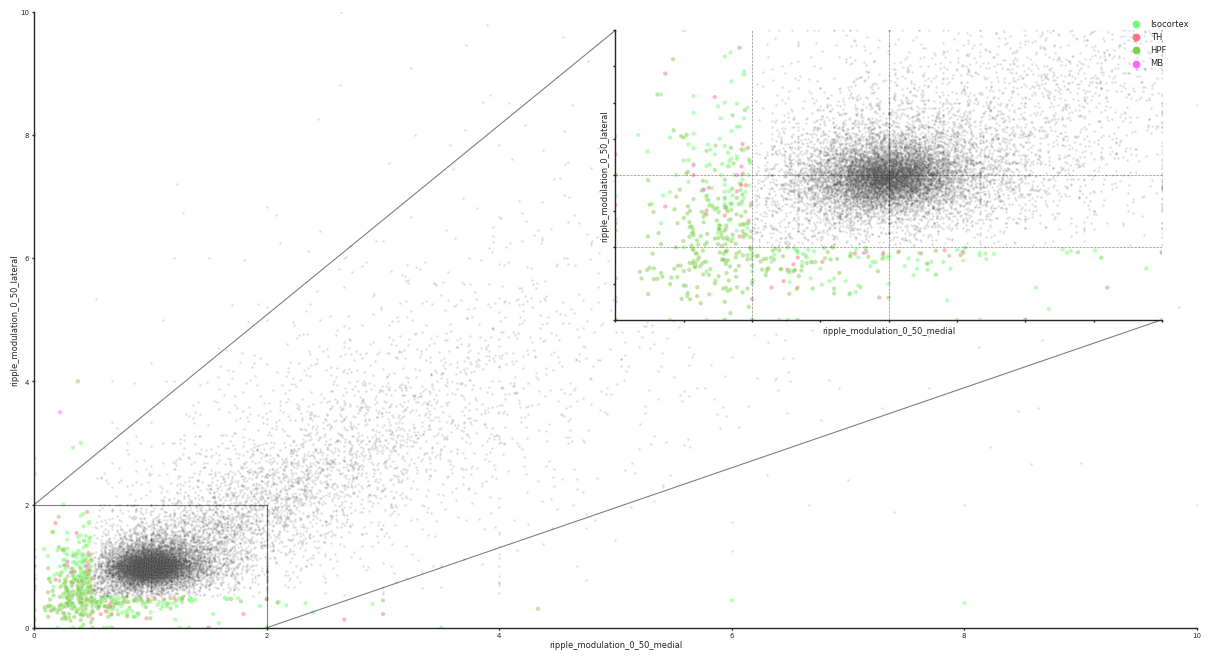

In [211]:
fig, axs = plt.subplots( 1 ,figsize=(15,8))
_ = summary_units_df_sub[summary_units_df_sub['Firing rate (100-20 ms)']>0.025]
sns.scatterplot(data=_[(_['Ripple modulation (0-50 ms) medial']<.5) | (_['Ripple modulation (0-50 ms) lateral']<.5)], x='Ripple modulation (0-50 ms) medial',
                y='Ripple modulation (0-50 ms) lateral', hue='Parent brain region', palette=palette_parent_areas, s=10, alpha=.5, ax=axs)
sns.scatterplot(data=_[(_['Ripple modulation (0-50 ms) medial']>.5) & (_['Ripple modulation (0-50 ms) lateral']>.5)], x='Ripple modulation (0-50 ms) medial',
                y='Ripple modulation (0-50 ms) lateral', color='.15', s=3, alpha=.15, ax=axs)
axs.set_xlim((0,10))
axs.set_ylim((0,10))

axins = axs.inset_axes([0.5, 0.5, 0.47, 0.47])
sns.scatterplot(data=_[(_['Ripple modulation (0-50 ms) medial']<.5) | (_['Ripple modulation (0-50 ms) lateral']<.5)], x='Ripple modulation (0-50 ms) medial',
                y='Ripple modulation (0-50 ms) lateral', hue='Parent brain region', palette=palette_parent_areas, s=10, alpha=.5, ax=axins, legend=False)
sns.scatterplot(data=_[(_['Ripple modulation (0-50 ms) medial']>.5) & (_['Ripple modulation (0-50 ms) lateral']>.5)], x='Ripple modulation (0-50 ms) medial',
                y='Ripple modulation (0-50 ms) lateral', color='.15', s=3, alpha=.15, ax=axins, legend=False)
# subregion of the original image
x1, x2, y1, y2 = 0, 2, 0, 2
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.axvline(.5,  alpha=.5, linestyle='--', color='k')
axins.axhline(.5,  alpha=.5, linestyle='--', color='k')
axins.axvline(1,  alpha=.5, linestyle='--', color='k')
axins.axhline(1,  alpha=.5, linestyle='--', color='k')

axs.indicate_inset_zoom(axins, edgecolor='black')


(<matplotlib.patches.Rectangle at 0x7f2c228e28d0>,
 (<matplotlib.patches.ConnectionPatch at 0x7f2c228e22d0>,
  <matplotlib.patches.ConnectionPatch at 0x7f2c229f0b10>))

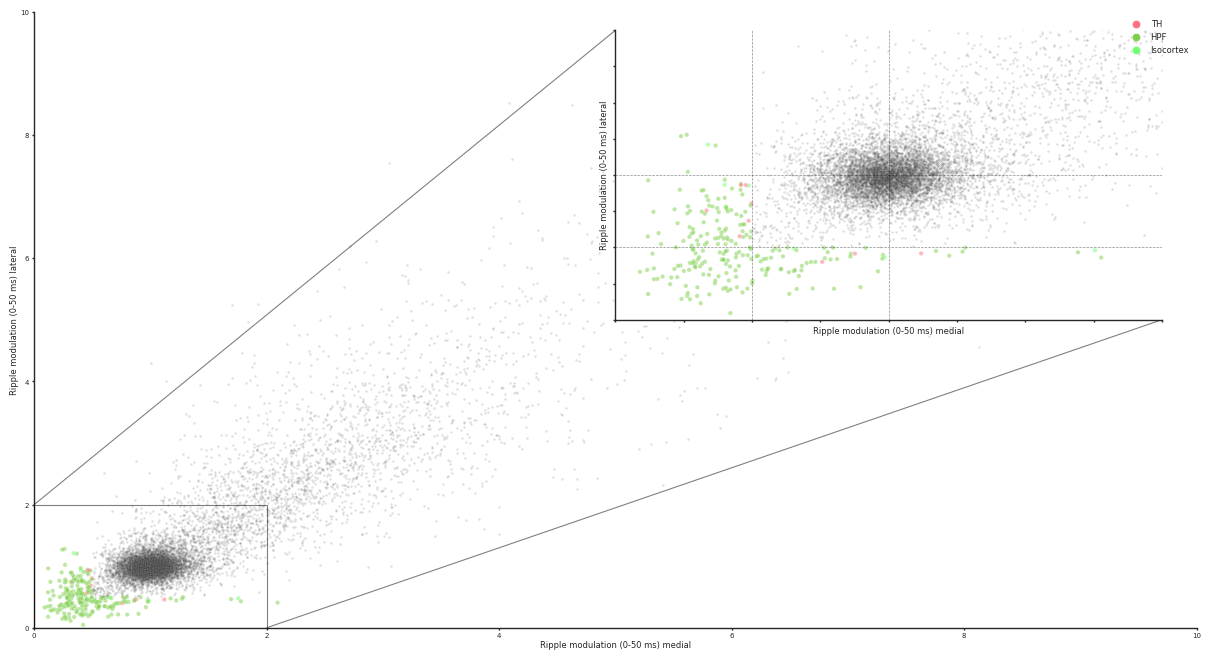

In [83]:
fig, axs = plt.subplots( 1 ,figsize=(15,8))
_ = summary_units_df_sub[summary_units_df_sub['Firing rate (100-20 ms)']>0.025]
sns.scatterplot(data=_[(_['Ripple modulation (0-50 ms) medial']<.5) | (_['Ripple modulation (0-50 ms) lateral']<.5)], x='Ripple modulation (0-50 ms) medial',
                y='Ripple modulation (0-50 ms) lateral', hue='Parent brain region', palette=palette_parent_areas, s=10, alpha=.5, ax=axs)
sns.scatterplot(data=_[(_['Ripple modulation (0-50 ms) medial']>.5) & (_['Ripple modulation (0-50 ms) lateral']>.5)], x='Ripple modulation (0-50 ms) medial',
                y='Ripple modulation (0-50 ms) lateral', color='.15', s=3, alpha=.15, ax=axs)
axs.set_xlim((0,10))
axs.set_ylim((0,10))

axins = axs.inset_axes([0.5, 0.5, 0.47, 0.47])
sns.scatterplot(data=_[(_['Ripple modulation (0-50 ms) medial']<.5) | (_['Ripple modulation (0-50 ms) lateral']<.5)], x='Ripple modulation (0-50 ms) medial',
                y='Ripple modulation (0-50 ms) lateral', hue='Parent brain region', palette=palette_parent_areas, s=10, alpha=.5, ax=axins, legend=False)
sns.scatterplot(data=_[(_['Ripple modulation (0-50 ms) medial']>.5) & (_['Ripple modulation (0-50 ms) lateral']>.5)], x='Ripple modulation (0-50 ms) medial',
                y='Ripple modulation (0-50 ms) lateral', color='.15', s=3, alpha=.15, ax=axins, legend=False)
# subregion of the original image
x1, x2, y1, y2 = 0, 2, 0, 2
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.axvline(.5,  alpha=.5, linestyle='--', color='k')
axins.axhline(.5,  alpha=.5, linestyle='--', color='k')
axins.axvline(1,  alpha=.5, linestyle='--', color='k')
axins.axhline(1,  alpha=.5, linestyle='--', color='k')

axs.indicate_inset_zoom(axins, edgecolor='black')


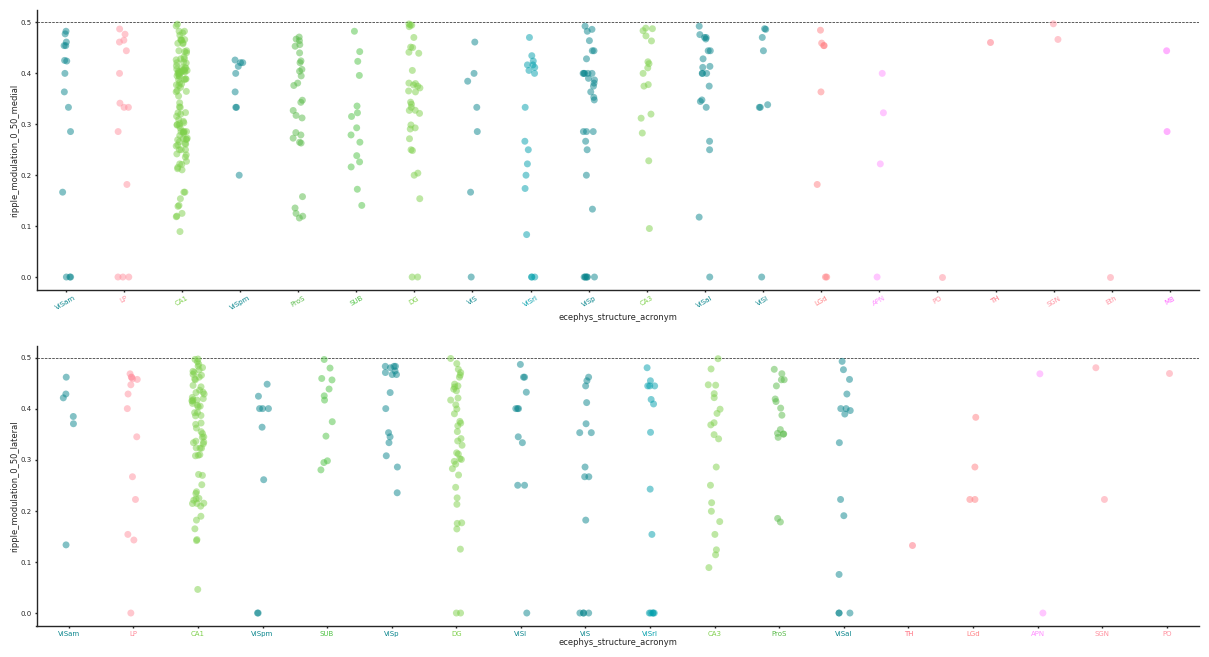

In [36]:
fig, axs = plt.subplots( 2, figsize=(15,8))
axs[0].axhline(.5,color= 'k', linestyle='--')
sns.stripplot(data=summary_units_df_sub[summary_units_df_sub['Ripple modulation (0-50 ms) medial']<.5], y='Ripple modulation (0-50 ms) medial', x='Brain region', palette=palette_areas, alpha=.5, s=5, ax=axs[0])
color_to_labels(axs[0], 'x', 'major', 1);
sns.stripplot(data=summary_units_df_sub[summary_units_df_sub['Ripple modulation (0-50 ms) lateral']<.5], y='Ripple modulation (0-50 ms) lateral', x='Brain region', palette=palette_areas, alpha=.5, s=5, ax=axs[1])
color_to_labels(axs[1], 'x', 'major', 1);
axs[1].axhline(.5,color= 'k', linestyle='--')

props = {'rotation' : 30}
plt.setp(axs[0].get_xticklabels(), **props);
plt.setp(axs[0].get_xticklabels(), **props);

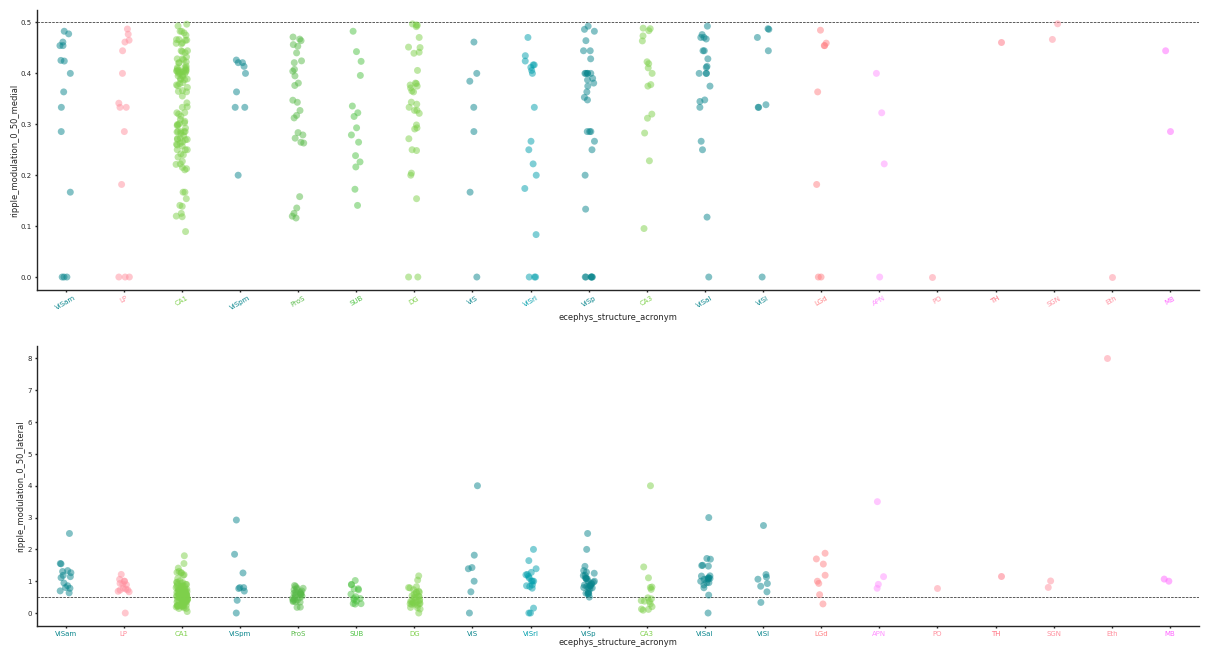

In [37]:
fig, axs = plt.subplots( 2, figsize=(15,8))
axs[0].axhline(.5,color= 'k', linestyle='--')
sns.stripplot(data=summary_units_df_sub[summary_units_df_sub['Ripple modulation (0-50 ms) medial']<.5], y='Ripple modulation (0-50 ms) medial', x='Brain region', palette=palette_areas, alpha=.5, s=5, ax=axs[0])
color_to_labels(axs[0], 'x', 'major', 1);
sns.stripplot(data=summary_units_df_sub[summary_units_df_sub['Ripple modulation (0-50 ms) medial']<.5], y='Ripple modulation (0-50 ms) lateral', x='Brain region', palette=palette_areas, alpha=.5, s=5, ax=axs[1])
color_to_labels(axs[1], 'x', 'major', 1);
axs[1].axhline(.5,color= 'k', linestyle='--')

props = {'rotation' : 30}
plt.setp(axs[0].get_xticklabels(), **props);
plt.setp(axs[0].get_xticklabels(), **props);

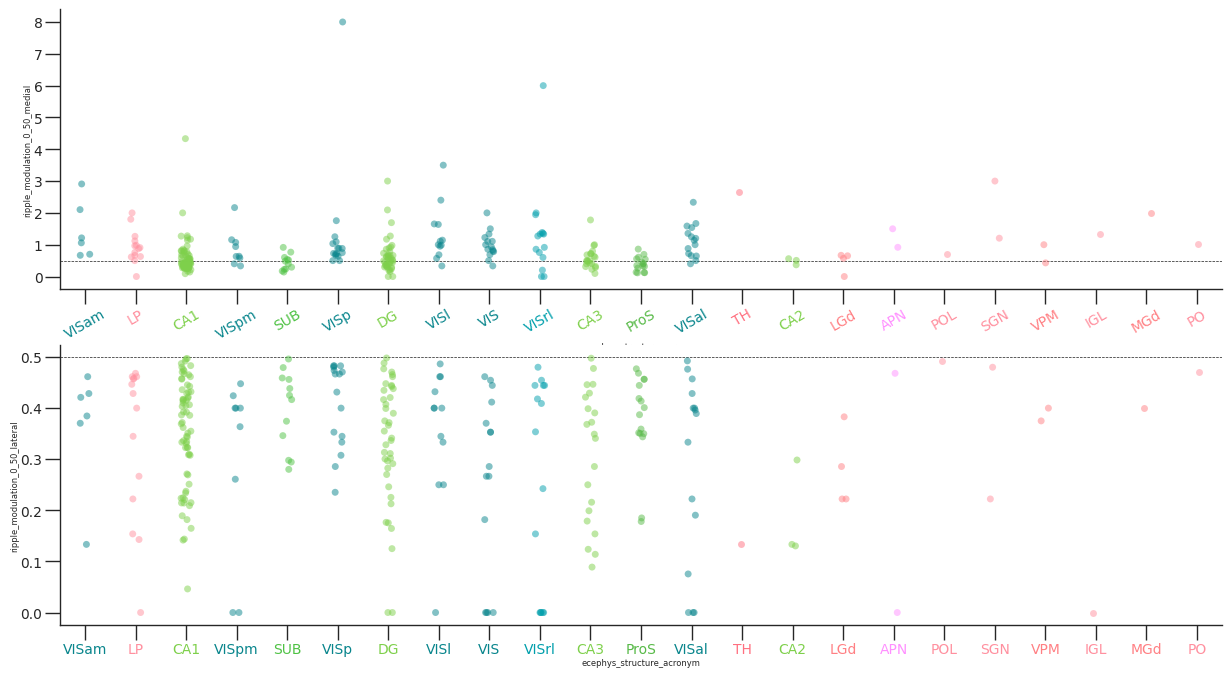

In [912]:
fig, axs = plt.subplots( 2, figsize=(15,8))
axs[0].axhline(.5,color= 'k', linestyle='--')
sns.stripplot(data=summary_units_df_sub[summary_units_df_sub['Ripple modulation (0-50 ms) lateral']<.5], y='Ripple modulation (0-50 ms) medial', x='Brain region', palette=palette_areas, alpha=.5, s=5, ax=axs[0])
color_to_labels(axs[0], 'x', 'major', 1);
sns.stripplot(data=summary_units_df_sub[summary_units_df_sub['Ripple modulation (0-50 ms) lateral']<.5], y='Ripple modulation (0-50 ms) lateral', x='Brain region', palette=palette_areas, alpha=.5, s=5, ax=axs[1])
color_to_labels(axs[1], 'x', 'major', 1);
axs[1].axhline(.5,color= 'k', linestyle='--')

props = {'rotation' : 30}
plt.setp(axs[0].get_xticklabels(), **props);
plt.setp(axs[0].get_xticklabels(), **props);

In [53]:
summary_units_df_sub[summary_units_df_sub['Brain region']=='CA1'][['Diff ripple modulation (0-50 ms)','M-L',
                                                                                'anterior_posterior_ccf_coordinate', 'dorsal_ventral_ccf_coordinate']].corr().loc[['Diff ripple modulation (0-50 ms)']
                                                                                , ['M-L',
                                                                                'anterior_posterior_ccf_coordinate', 'dorsal_ventral_ccf_coordinate']]**2
                                                                                

,left_right_ccf_coordinate,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate
diff_ripple_modulation_0_50,0.055824,0.021963,0.039599


# units waveforms

In [4]:
with open(f'{output_folder_calculations}/clusters_features_per_section.pkl', 'rb') as f:
    total_clusters = dill.load(f)

In [5]:
from Utils.Settings import output_folder_calculations, output_folder_supplementary, var_thr, waveform_PT_ratio_thr, waveform_dur_thr , isi_violations_thr, amplitude_cutoff_thr, presence_ratio_thr, Adapt_for_Nature_style

HPF_units = total_clusters[(total_clusters["waveform_PT_ratio"]<waveform_PT_ratio_thr)&
                             (total_clusters["isi_violations"]<isi_violations_thr)&
                             (total_clusters["amplitude_cutoff"]<amplitude_cutoff_thr)&
                             (total_clusters["presence_ratio"]>presence_ratio_thr)]


In [578]:
exc_med = []
inh_med = []
exc_lat = []
inh_lat = []


for session_id in tqdm(HPF_units.session_id.unique()):
    session = cache.get_session_data(session_id)
    
    sub_units = HPF_units[HPF_units["session_id"]==session_id]
    
    sub_units = sub_units[sub_units["ecephys_structure_acronym"]=="CA1"]
    
    inh_units_med = sub_units[(sub_units["waveform_duration"]<waveform_dur_thr) & (sub_units["Location"]=="Medial")]
    exc_units_med = sub_units[(sub_units["waveform_duration"]>=waveform_dur_thr)& (sub_units["Location"]=="Medial")]
    inh_units_lat = sub_units[(sub_units["waveform_duration"]<waveform_dur_thr) & (sub_units["Location"]=="Lateral")]
    exc_units_lat = sub_units[(sub_units["waveform_duration"]>=waveform_dur_thr)& (sub_units["Location"]=="Lateral")]
    
    for unit_id in inh_units_med.index:
        try: 
            peak_channel = session.units.loc[unit_id].peak_channel_id
            wv = session.mean_waveforms[unit_id].sel(channel_id = peak_channel).to_numpy()
            inh_med.append(wv)
        except:
            continue
    for unit_id in exc_units_med.index:
        try:
            peak_channel = session.units.loc[unit_id].peak_channel_id
            wv = session.mean_waveforms[unit_id].sel(channel_id = peak_channel).to_numpy()
            exc_med.append(wv)
        except:
            continue
    for unit_id in inh_units_lat.index:
        try: 
            peak_channel = session.units.loc[unit_id].peak_channel_id
            wv = session.mean_waveforms[unit_id].sel(channel_id = peak_channel).to_numpy()
            inh_lat.append(wv)
        except:
            continue
    for unit_id in exc_units_lat.index:
        try:
            peak_channel = session.units.loc[unit_id].peak_channel_id
            wv = session.mean_waveforms[unit_id].sel(channel_id = peak_channel).to_numpy()
            exc_lat.append(wv)
        except:
            continue
        
    

  0%|          | 0/35 [00:00<?, ?it/s]

In [587]:
with open(f"{output_folder_calculations}/CA1_waveforms.pkl", "wb") as fp:
    dill.dump([exc_lat, exc_med, inh_lat, inh_med, session.mean_waveforms[951188452].time.to_numpy()], fp)

In [588]:
with open(f'{output_folder_calculations}/CA1_waveforms.pkl', 'rb') as f:
    exc_lat, exc_med, inh_lat, inh_med, time = dill.load(f)

(0.25, 1.5)

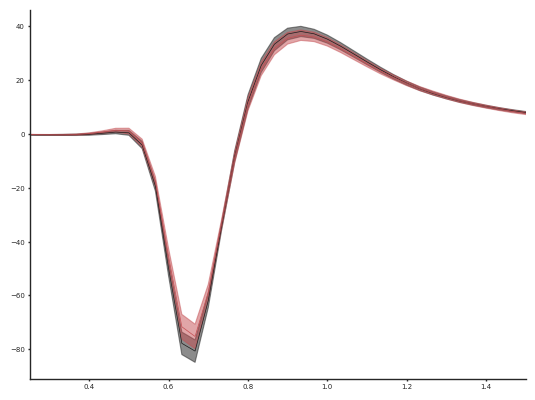

In [595]:
x = time*1000
y = pd.DataFrame(np.vstack(inh_lat), columns=time*1000).mean()
error = pd.DataFrame(np.vstack(inh_lat), columns=time*1000).sem() 

plt.fill_between(x, y-error, y+error, color="k", alpha=.5)
plt.plot(x,y, color="k")

y = pd.DataFrame(np.vstack(inh_med), columns=time*1000).mean()
error = pd.DataFrame(np.vstack(inh_med), columns=time*1000).sem() 

plt.fill_between(x, y-error, y+error, color="r", alpha=.5)
plt.plot(x,y, color="r")
plt.xlim((0.25,1.5))

(0.25, 2.0)

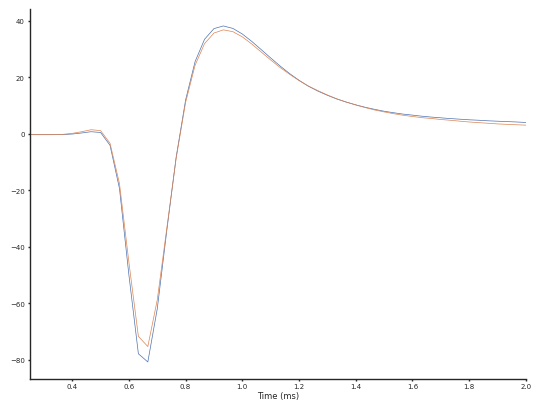

In [594]:
fig, ax = plt.subplots()
pd.DataFrame(np.vstack(inh_lat), columns=time*1000).mean().plot(ax=ax)
pd.DataFrame(np.vstack(inh_med), columns=time*1000).mean().plot(ax=ax)
ax.set_xlabel("Time (ms)")
#ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.set_xlim((0.25, 2))

(0.25, 2.0)

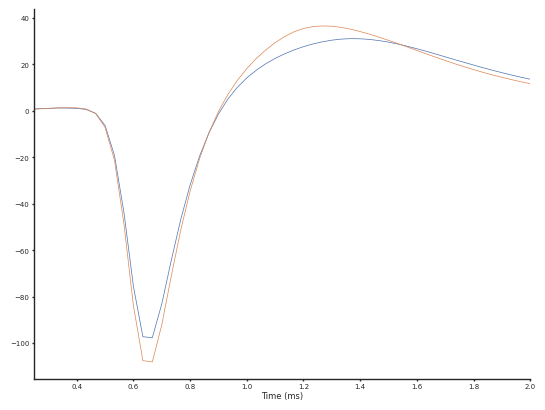

In [593]:
fig, ax = plt.subplots()
pd.DataFrame(np.vstack(exc_lat), columns=time*1000).mean().plot(ax=ax)
pd.DataFrame(np.vstack(exc_med), columns=time*1000).mean().plot(ax=ax)
ax.set_xlabel("Time (ms)")
#ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.set_xlim((0.25,2))

In [ ]:
from Utils.Style import palette_ML

<AxesSubplot:>

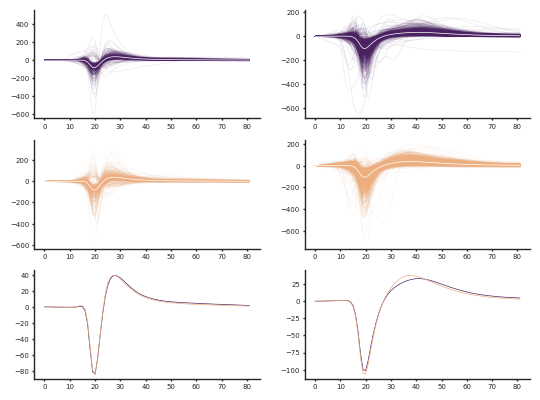

In [59]:
fig, ax = plt.subplots(3,2)
pd.DataFrame(np.vstack(exc_lat).T).plot(alpha=.1, color=palette_ML["Lateral"], legend=False, ax=ax[0,1])
pd.DataFrame(np.vstack(exc_lat)).mean().plot( color="w", ax=ax[0,1])

pd.DataFrame(np.vstack(exc_med).T).plot(alpha=.1, color=palette_ML["Medial"], legend=False, ax=ax[1,1])
pd.DataFrame(np.vstack(exc_med)).mean().plot( color="w", ax=ax[1,1])

pd.DataFrame(np.vstack(exc_lat)).mean().plot( color=palette_ML["Lateral"], ax=ax[2,1])
pd.DataFrame(np.vstack(exc_med)).mean().plot( color=palette_ML["Medial"], ax=ax[2,1])

pd.DataFrame(np.vstack(inh_lat).T).plot(alpha=.1, color=palette_ML["Lateral"], legend=False, ax=ax[0,0])
pd.DataFrame(np.vstack(inh_lat)).mean().plot( color="w", ax=ax[0,0])

pd.DataFrame(np.vstack(inh_med).T).plot(alpha=.1, color=palette_ML["Medial"], legend=False, ax=ax[1,0])
pd.DataFrame(np.vstack(inh_med)).mean().plot( color="w", ax=ax[1,0])

pd.DataFrame(np.vstack(inh_lat)).mean().plot( color=palette_ML["Lateral"], ax=ax[2,0])
pd.DataFrame(np.vstack(inh_med)).mean().plot( color=palette_ML["Medial"], ax=ax[2,0])